In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%%capture

!pip install codecarbon

In [ ]:
import os
import cv2
import copy
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.math import reduce_sum
from tensorflow.keras.layers import *
from codecarbon import EmissionsTracker

In [ ]:
# Hyperparameters that will be used for training: batch size, lr, number of epochs...
BATCH_SIZE = 8
LR = 0.0001
MOMENTUM = 0.98
EPOCHS = 2
INPUT_SIZE = (512, 512)
INP_CHANNELS = 1
OUT_MASKS = 1

In [ ]:
# Path to my dataset: EDIT IT WITH YOUR OWN PATH to the folder
path = "MY_PATH"
train_path = os.path.join(path, "training")
valid_path = os.path.join(path, "validation")
test_path = os.path.join(path, "testing")

In [ ]:
imgs = os.listdir(os.path.join(train_path, 'masks'))
print(imgs)

['doc_NR.front.289855_dl_gre.jpg', 'ic_CIE.front.10830.jpg', 'doc_NR.rear.332708_dl_gbr.jpg', 'doc_NR.front.307098_ic_gre.jpg', 'doc_NR.front.350756_ic_esp.jpg', 'doc_NR.front.332724_dl_gbr.jpg', 'doc_NR.rear.337684_ic_fra.jpg', 'ic_CIE.front.10667.jpg', 'doc_NR.rear.345865_ic_pol.jpg', 'doc_NR.front.339442_dl_pol.jpg', 'doc_NR.front.227845_dl_gre.jpg', 'doc_NR.front.295937_dl_fra.jpg', 'doc_NR.front.332707_dl_gbr.jpg', 'doc_NR.rear.339443_dl_pol.jpg', 'doc_NR.rear.344552_ic_deu.jpg', 'doc_NR.rear.307097_ic_gre.jpg', 'doc_NR.rear.353282_ic_rou.jpg', 'doc_NR.rear.350784_ic_esp.jpg', 'doc_NR.front.197317_dl_fra.jpg', 'doc_NR.rear.227846_dl_gre.jpg', 'doc_NR.rear.295936_dl_fra.jpg', 'doc_NR.front.340498_dl_deu.jpg', 'doc_NR.rear.197318_dl_fra.jpg', 'doc_NR.front.159273_ic_pol.jpg', 'doc_NR.rear.332725_dl_gbr.jpg', 'doc_NR.front.223144_dl_pol.jpg', 'doc_NR.rear.340499_dl_deu.jpg', 'doc_NR.front.353281_ic_rou.jpg', 'doc_NR.front.345862_ic_pol.jpg', 'doc_NR.rear.260757_dl_esp.jpg', 'doc_NR.f

In [ ]:
# preprocess images

def preprocess(img, mask):
  img = cv2.resize(img, (INPUT_SIZE[1], INPUT_SIZE[0]))
  img = (img - np.mean(img))/np.std(img)

  mask = cv2.resize(mask, (INPUT_SIZE[1], INPUT_SIZE[0]))
  mask = mask / 255

  return img, mask

In [ ]:
def get_dataset(path):
  imgs = os.listdir(os.path.join(path, 'images'))

  X = np.empty((len(imgs), *INPUT_SIZE, INP_CHANNELS))
  y = np.empty((len(imgs), *INPUT_SIZE, INP_CHANNELS))

  for idx, img in enumerate(imgs):
    image = cv2.imread(os.path.join(path, 'images', img))[:, :, 0] #leggiamo solo un canale
    if idx == 0:
      print("orginal image size:", image.shape)
    print(f"\rloading: {idx/len(imgs):.3f}%", end="")
    image = cv2.resize(image, (INPUT_SIZE[1], INPUT_SIZE[0]))
    mask = cv2.imread(os.path.join(path, 'masks', img))[:, :, 0]

    # Normalize each image: (img-mean)/stand_dev

    image, mask = preprocess(image, mask)
    X[idx, :, :, 0] = image
    y[idx, :, :, 0] = mask

  print()

  return X, y

In [ ]:
# Create train and valid dataset

X_train, y_train = get_dataset(train_path)
X_valid, y_valid = get_dataset(valid_path)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

NameError: ignored

In [ ]:
# Create test dataset

X_test, y_test = get_dataset(test_path)

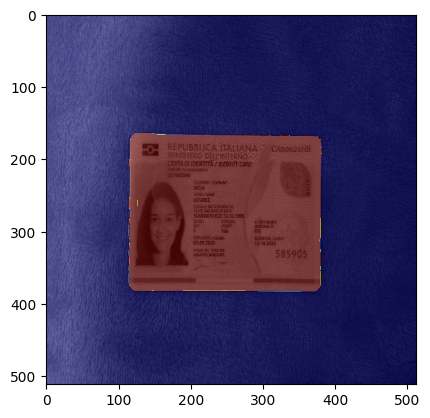

In [ ]:
# Get sample images

plt.figure(1)
plt.imshow(X_train[17], cmap='gray')
plt.imshow(y_train[17], 'jet', interpolation='none', alpha=0.5)

In [ ]:
# Data augmentation

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed):
    super().__init__()
    self.rotate_inputs = RandomRotation(factor=0.1, seed=seed)
    self.rotate_labels = RandomRotation(factor=0.1, seed=seed)
    self.shift_inputs = RandomTranslation(height_factor=0.1, width_factor=0.1, seed=seed)
    self.shift_labels = RandomTranslation(height_factor=0.1, width_factor=0.1, seed=seed)


  def call(self, inputs, labels):
    inputs = self.rotate_inputs(inputs)
    inputs = self.shift_inputs(inputs)
    labels = self.rotate_labels(labels)
    labels = self.shift_labels(labels)
    return inputs, labels

In [ ]:
# Generator

class DataGenerator(Sequence):
    def __init__(self, inputs, masks, batch_size, augment=None, shuffle=True):
        'The constructor can be expanded with as many attributes as needed'
        self.inputs = inputs
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment_class = augment
        self.img_size = INPUT_SIZE
        self.inp_chan = INP_CHANNELS
        self.out_chan = OUT_MASKS

        self.on_epoch_end()
    # Take all batches in each iteration'
    def __len__(self):
        return int(np.floor(len(self.inputs) / self.batch_size))

    # Get next batch
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    # Updates indexes after each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.inputs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # Generates data containing batch_size samples
    def __data_generation(self, list_idx):
        X = np.empty((self.batch_size, *self.img_size, self.inp_chan), dtype=np.float32) #l'asterisco spacchetta il numero di immagini
        Y = np.empty((self.batch_size, *self.img_size, self.out_chan), dtype=np.float32)
        for i_batch, id in enumerate(list_idx):
          # Store samples and masks
          img = self.inputs[id]
          mask = self.masks[id]

          # Augment
          if self.augment_class is not None:
            augment = self.augment_class(seed=random.randint(0,100))
            img, mask = augment(img, mask)

          X[i_batch, :, :, :] = img
          Y[i_batch, :, :, :] = mask

        return X, Y

In [ ]:
train_generator = DataGenerator(
    inputs=X_train, masks=y_train, batch_size=BATCH_SIZE, augment=Augment)
valid_generator = DataGenerator(
    inputs=X_valid, masks=y_valid, batch_size=BATCH_SIZE)


In [ ]:
test_generator = DataGenerator(
    inputs=X_test, masks=y_test, batch_size=BATCH_SIZE)

In [ ]:
# Asymmetric convolutions

# def encoder_stage(inp, filters):
#     x = conv_stage(inp, filters)
#     p = MaxPooling2D(pool_size=(2, 2))(x)
#     return x, p

# def conv_stage(inp, filters, act=True):
#     x = Conv2D(filters, (3, 1), padding='same', activation='relu')(inp)
#     x = Conv2D(filters, (1, 3), padding='same', activation='relu')(x)
#     x = Conv2D(filters, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     if act:
#         x = Activation('relu')(x)
#     return x

# def decoder_stage(inp, filters, concat_layer):
#     x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inp)
#     concat_layer = conv_stage(concat_layer, filters)
#     x = concatenate([x, concat_layer])
#     x = conv_stage(x, filters)
#     return x

# def unet(input_size=(*INPUT_SIZE, INP_CHANNELS)):
#     inputs = Input(input_size)
#     d1, p1 = encoder_stage(inputs, 64)
#     d2, p2 = encoder_stage(p1, 128)
#     d3, p3 = encoder_stage(p2, 256)
#     d4, p4 = encoder_stage(p3, 512)
#     b1 = conv_stage(p4, 1024)
#     e2 = decoder_stage(b1, 512, d4)
#     e3 = decoder_stage(e2, 256, d3)
#     e4 = decoder_stage(e3, 128, d2)
#     e5 = decoder_stage(e4, 64, d1)

#     e5 = Conv2D(OUT_MASKS, (1, 1))(e5)
#     outputs = Activation('sigmoid')(e5)

#     return Model(inputs=inputs, outputs=outputs, name='Unet')

In [ ]:
# Classic convolutions

def encoder_stage(input, stage):
  encod = Conv2D(64*(2**stage), 3, activation='relu', padding='same')(input)
  encod = Conv2D(64*(2**stage), 3, activation='relu', padding='same')(encod)
  pool = MaxPooling2D(pool_size=(2, 2))(encod)
  return pool, encod


def decoder_stage(input, stage, skip_connection):
  decod = UpSampling2D(size = (2,2))(input)
  decod = Conv2D(512/(2**stage), 2, activation='relu', padding='same')(decod)
  decod = concatenate([skip_connection, decod], axis=3)
  decod = Conv2D(512/(2**stage), 3, activation='relu', padding='same')(decod)
  return Conv2D(512/(2**stage), 3, activation='relu', padding='same')(decod)


def unet(input_size=(*INPUT_SIZE, 1)):
    inputs = Input(input_size)

    # encoder
    pooled1, conv1 = encoder_stage(inputs, 0)
    pooled2, conv2 = encoder_stage(pooled1, 1)
    pooled3, conv3 = encoder_stage(pooled2, 2)
    pooled4, conv4 = encoder_stage(pooled3, 3)

    # bottleneck
    bn = Conv2D(1024, 3, activation='relu', padding='same')(pooled4)
    bn = Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    upconv1 = decoder_stage(bn, 0, conv4)
    upconv2 = decoder_stage(upconv1, 1, conv3)
    upconv3 = decoder_stage(upconv2, 2, conv2)
    upconv4 = decoder_stage(upconv3, 3, conv1)

    # Output
    out = Conv2D(16, 3, activation = 'relu', padding = 'same')(upconv4)
    out = Conv2D(1, 1, activation = 'sigmoid')(out)

    return Model(inputs, out)

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, name="dice_loss"):
        super(DiceLoss, self).__init__(name=name)
        self.redsum = tf.math.reduce_sum

    def call(self, y_true, y_pred, smooth=0.01):
        intersec = self.redsum(y_true * y_pred)
        dice = (2 * intersec + smooth) / (self.redsum(y_true) + self.redsum(y_pred) + smooth)
        return 1 - dice


In [ ]:
# Define IoU

iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])

In [ ]:
# Define our model

model = unet()
model.compile(optimizer=Adam(learning_rate=LR), loss=DiceLoss(), metrics=iou)

save_filename = "u_net_softmax"

In [ ]:
#Compile model

train_path = os.path.join(path, "MY_PATH")
if not os.path.exists(train_path):
  os.mkdir(train_path)

callbacks_list = ModelCheckpoint(os.path.join(train_path, f"{save_filename}.hdf5"),
                                 monitor='val_loss', verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(train_path, f"{save_filename}.csv"),
                       append=True, separator=';')



In [ ]:
#Start fit

tracker = EmissionsTracker()
tracker.start()

history = model.fit(train_generator, validation_data=valid_generator, epochs=50, verbose=1, callbacks=[callbacks_list, csv_logger])

emissions: float = tracker.stop()
print(f"Emissions: {emissions} kg")

[codecarbon INFO @ 14:08:20] [setup] RAM Tracking...
[codecarbon INFO @ 14:08:20] [setup] GPU Tracking...
[codecarbon INFO @ 14:08:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:08:20] [setup] CPU Tracking...
[codecarbon WARNING @ 14:08:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:08:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:08:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:08:23] >>> Tracker's metadata:
[codecarbon INFO @ 14:08:23]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 14:08:23]   Python version: 3.10.12
[codecarbon INFO @ 14:08:23]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 14:08:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 14:08:23]   CPU count: 2
[codecarbon INFO @ 14:08:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:08:23]   GPU

Epoch 1/50


[codecarbon INFO @ 14:08:38] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:08:38] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 29.824 W
[codecarbon INFO @ 14:08:38] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:08:38] 0.000322 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:53] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:08:53] Energy consumed for all GPUs : 0.000422 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 14:08:53] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:08:53] 0.000816 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:09:08] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:09:08] Energy consumed for all GPUs : 0.000716 kWh. Total GPU Power : 70.586 W
[codecarbon INFO @ 14:09:08] E

 4/40 [==>...........................] - ETA: 1:35 - loss: 0.6271 - io_u: 0.7008

[codecarbon INFO @ 14:09:53] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:09:53] Energy consumed for all GPUs : 0.001673 kWh. Total GPU Power : 43.523 W
[codecarbon INFO @ 14:09:53] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:09:53] 0.002855 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:24 - loss: 0.6332 - io_u: 0.7161

[codecarbon INFO @ 14:10:08] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:10:08] Energy consumed for all GPUs : 0.001935 kWh. Total GPU Power : 63.004000000000005 W
[codecarbon INFO @ 14:10:08] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:08] 0.003314 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:08 - loss: 0.5923 - io_u: 0.6873

[codecarbon INFO @ 14:10:23] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:10:23] Energy consumed for all GPUs : 0.002120 kWh. Total GPU Power : 44.508 W
[codecarbon INFO @ 14:10:23] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:23] 0.003696 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 54s - loss: 0.5784 - io_u: 0.7005

[codecarbon INFO @ 14:10:38] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:10:38] Energy consumed for all GPUs : 0.002413 kWh. Total GPU Power : 70.39000000000001 W
[codecarbon INFO @ 14:10:38] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:38] 0.004185 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 37s - loss: 0.5572 - io_u: 0.6984

[codecarbon INFO @ 14:10:53] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:10:53] Energy consumed for all GPUs : 0.002703 kWh. Total GPU Power : 69.006 W
[codecarbon INFO @ 14:10:53] Energy consumed for all CPUs : 0.001773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:10:53] 0.004674 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 24s - loss: 0.5410 - io_u: 0.6944

[codecarbon INFO @ 14:11:08] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:11:08] Energy consumed for all GPUs : 0.003001 kWh. Total GPU Power : 71.467 W
[codecarbon INFO @ 14:11:08] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:11:08] 0.005168 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 8s - loss: 0.5294 - io_u: 0.6943 

[codecarbon INFO @ 14:11:23] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:11:23] Energy consumed for all GPUs : 0.003283 kWh. Total GPU Power : 67.731 W
[codecarbon INFO @ 14:11:23] Energy consumed for all CPUs : 0.002127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:11:23] 0.005647 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.5240 - io_u: 0.6954

[codecarbon INFO @ 14:11:38] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:11:38] Energy consumed for all GPUs : 0.003467 kWh. Total GPU Power : 44.311 W
[codecarbon INFO @ 14:11:38] Energy consumed for all CPUs : 0.002304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:11:38] 0.006029 kWh of electricity used since the beginning.



Epoch 1: val_loss improved from inf to 0.46441, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 202s 3s/step - loss: 0.5240 - io_u: 0.6954 - val_loss: 0.4644 - val_io_u: 0.7401
Epoch 2/50
 2/40 [>.............................] - ETA: 1:45 - loss: 0.4486 - io_u: 0.7424

[codecarbon INFO @ 14:11:53] Energy consumed for RAM : 0.000278 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:11:53] Energy consumed for all GPUs : 0.003784 kWh. Total GPU Power : 73.229 W
[codecarbon INFO @ 14:11:53] Energy consumed for all CPUs : 0.002488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:11:53] 0.006549 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:30 - loss: 0.4527 - io_u: 0.7288

[codecarbon INFO @ 14:12:08] Energy consumed for RAM : 0.000298 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:12:08] Energy consumed for all GPUs : 0.004085 kWh. Total GPU Power : 72.446 W
[codecarbon INFO @ 14:12:08] Energy consumed for all CPUs : 0.002665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:08] 0.007047 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:13 - loss: 0.4407 - io_u: 0.7115

[codecarbon INFO @ 14:12:23] Energy consumed for RAM : 0.000318 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:12:23] Energy consumed for all GPUs : 0.004357 kWh. Total GPU Power : 65.418 W
[codecarbon INFO @ 14:12:23] Energy consumed for all CPUs : 0.002842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:23] 0.007517 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 56s - loss: 0.4400 - io_u: 0.7241

[codecarbon INFO @ 14:12:38] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:12:38] Energy consumed for all GPUs : 0.004644 kWh. Total GPU Power : 68.96300000000001 W
[codecarbon INFO @ 14:12:38] Energy consumed for all CPUs : 0.003019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:38] 0.008000 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 43s - loss: 0.4409 - io_u: 0.7191

[codecarbon INFO @ 14:12:53] Energy consumed for RAM : 0.000357 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:12:53] Energy consumed for all GPUs : 0.004932 kWh. Total GPU Power : 69.159 W
[codecarbon INFO @ 14:12:53] Energy consumed for all CPUs : 0.003196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:53] 0.008485 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.4144 - io_u: 0.6983

[codecarbon INFO @ 14:13:08] Energy consumed for RAM : 0.000377 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:13:08] Energy consumed for all GPUs : 0.005237 kWh. Total GPU Power : 73.327 W
[codecarbon INFO @ 14:13:08] Energy consumed for all CPUs : 0.003373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:13:08] 0.008987 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.4064 - io_u: 0.7024

[codecarbon INFO @ 14:13:23] Energy consumed for RAM : 0.000397 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:13:23] Energy consumed for all GPUs : 0.005422 kWh. Total GPU Power : 44.436 W
[codecarbon INFO @ 14:13:23] Energy consumed for all CPUs : 0.003550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:13:23] 0.009369 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.4025 - io_u: 0.7023

[codecarbon INFO @ 14:13:38] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:13:38] Energy consumed for all GPUs : 0.005701 kWh. Total GPU Power : 67.045 W
[codecarbon INFO @ 14:13:38] Energy consumed for all CPUs : 0.003727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:13:38] 0.009845 kWh of electricity used since the beginning.



Epoch 2: val_loss improved from 0.46441 to 0.36278, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 120s 3s/step - loss: 0.4025 - io_u: 0.7023 - val_loss: 0.3628 - val_io_u: 0.7935
Epoch 3/50
 2/40 [>.............................] - ETA: 1:44 - loss: 0.2950 - io_u: 0.6821

[codecarbon INFO @ 14:13:53] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:13:53] Energy consumed for all GPUs : 0.005974 kWh. Total GPU Power : 65.516 W
[codecarbon INFO @ 14:13:53] Energy consumed for all CPUs : 0.003904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:13:53] 0.010315 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:29 - loss: 0.3001 - io_u: 0.7275

[codecarbon INFO @ 14:14:08] Energy consumed for RAM : 0.000456 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:14:08] Energy consumed for all GPUs : 0.006267 kWh. Total GPU Power : 70.237 W
[codecarbon INFO @ 14:14:08] Energy consumed for all CPUs : 0.004081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:14:08] 0.010804 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:12 - loss: 0.3333 - io_u: 0.7225

[codecarbon INFO @ 14:14:23] Energy consumed for RAM : 0.000476 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:14:23] Energy consumed for all GPUs : 0.006559 kWh. Total GPU Power : 70.33500000000001 W
[codecarbon INFO @ 14:14:23] Energy consumed for all CPUs : 0.004258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:14:23] 0.011293 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 56s - loss: 0.3170 - io_u: 0.7109

[codecarbon INFO @ 14:14:39] Energy consumed for RAM : 0.000496 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:14:39] Energy consumed for all GPUs : 0.006860 kWh. Total GPU Power : 69.551 W
[codecarbon INFO @ 14:14:39] Energy consumed for all CPUs : 0.004442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:14:39] 0.011799 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.3065 - io_u: 0.7187

[codecarbon INFO @ 14:14:54] Energy consumed for RAM : 0.000516 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:14:54] Energy consumed for all GPUs : 0.007044 kWh. Total GPU Power : 44.14 W
[codecarbon INFO @ 14:14:54] Energy consumed for all CPUs : 0.004619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:14:54] 0.012180 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.3032 - io_u: 0.7327

[codecarbon INFO @ 14:15:09] Energy consumed for RAM : 0.000536 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:15:09] Energy consumed for all GPUs : 0.007318 kWh. Total GPU Power : 65.811 W
[codecarbon INFO @ 14:15:09] Energy consumed for all CPUs : 0.004797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:15:09] 0.012651 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.2955 - io_u: 0.7455

[codecarbon INFO @ 14:15:24] Energy consumed for RAM : 0.000556 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:15:24] Energy consumed for all GPUs : 0.007638 kWh. Total GPU Power : 76.90300000000002 W
[codecarbon INFO @ 14:15:24] Energy consumed for all CPUs : 0.004974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:15:24] 0.013168 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2886 - io_u: 0.7485
Epoch 3: val_loss improved from 0.36278 to 0.19769, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:15:43] Energy consumed for RAM : 0.000581 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:15:43] Energy consumed for all GPUs : 0.007812 kWh. Total GPU Power : 33.268 W
[codecarbon INFO @ 14:15:43] Energy consumed for all CPUs : 0.005196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:15:43] 0.013589 kWh of electricity used since the beginning.


40/40 [==============================] - 121s 3s/step - loss: 0.2886 - io_u: 0.7485 - val_loss: 0.1977 - val_io_u: 0.7528
Epoch 4/50
 3/40 [=>............................] - ETA: 1:45 - loss: 0.2602 - io_u: 0.7194

[codecarbon INFO @ 14:15:58] Energy consumed for RAM : 0.000600 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:15:58] Energy consumed for all GPUs : 0.008092 kWh. Total GPU Power : 67.184 W
[codecarbon INFO @ 14:15:58] Energy consumed for all CPUs : 0.005373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:15:58] 0.014066 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:24 - loss: 0.2577 - io_u: 0.7445

[codecarbon INFO @ 14:16:13] Energy consumed for RAM : 0.000620 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:16:13] Energy consumed for all GPUs : 0.008355 kWh. Total GPU Power : 63.26 W
[codecarbon INFO @ 14:16:13] Energy consumed for all CPUs : 0.005550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:16:13] 0.014526 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:10 - loss: 0.2499 - io_u: 0.7202

[codecarbon INFO @ 14:16:28] Energy consumed for RAM : 0.000640 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:16:28] Energy consumed for all GPUs : 0.008640 kWh. Total GPU Power : 68.418 W
[codecarbon INFO @ 14:16:28] Energy consumed for all CPUs : 0.005728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:16:28] 0.015007 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 53s - loss: 0.2468 - io_u: 0.7383

[codecarbon INFO @ 14:16:43] Energy consumed for RAM : 0.000660 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:16:43] Energy consumed for all GPUs : 0.008936 kWh. Total GPU Power : 71.217 W
[codecarbon INFO @ 14:16:43] Energy consumed for all CPUs : 0.005904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:16:43] 0.015500 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 37s - loss: 0.2534 - io_u: 0.7342

[codecarbon INFO @ 14:16:58] Energy consumed for RAM : 0.000679 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:16:58] Energy consumed for all GPUs : 0.009243 kWh. Total GPU Power : 73.621 W
[codecarbon INFO @ 14:16:58] Energy consumed for all CPUs : 0.006081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:16:58] 0.016004 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.2577 - io_u: 0.7389

[codecarbon INFO @ 14:17:13] Energy consumed for RAM : 0.000699 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:17:13] Energy consumed for all GPUs : 0.009427 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:17:13] Energy consumed for all CPUs : 0.006259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:17:13] 0.016385 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.2616 - io_u: 0.7414 

[codecarbon INFO @ 14:17:28] Energy consumed for RAM : 0.000719 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:17:28] Energy consumed for all GPUs : 0.009722 kWh. Total GPU Power : 70.869 W
[codecarbon INFO @ 14:17:28] Energy consumed for all CPUs : 0.006435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:17:28] 0.016876 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2599 - io_u: 0.7514
Epoch 4: val_loss did not improve from 0.19769
40/40 [==============================] - 112s 3s/step - loss: 0.2599 - io_u: 0.7514 - val_loss: 0.2712 - val_io_u: 0.7530


[codecarbon INFO @ 14:17:43] Energy consumed for RAM : 0.000739 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:17:43] Energy consumed for all GPUs : 0.009861 kWh. Total GPU Power : 33.466 W
[codecarbon INFO @ 14:17:43] Energy consumed for all CPUs : 0.006612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:17:43] 0.017212 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:58] Energy consumed for RAM : 0.000759 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:17:58] Energy consumed for all GPUs : 0.009997 kWh. Total GPU Power : 32.694 W
[codecarbon INFO @ 14:17:58] Energy consumed for all CPUs : 0.006789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:17:58] 0.017545 kWh of electricity used since the beginning.


Epoch 5/50
 1/40 [..............................] - ETA: 1:44 - loss: 0.2224 - io_u: 0.8198

[codecarbon INFO @ 14:18:13] Energy consumed for RAM : 0.000779 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:18:13] Energy consumed for all GPUs : 0.010293 kWh. Total GPU Power : 70.47700000000002 W
[codecarbon INFO @ 14:18:13] Energy consumed for all CPUs : 0.006968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:18:13] 0.018039 kWh of electricity used since the beginning.


 6/40 [===>..........................] - ETA: 1:33 - loss: 0.2245 - io_u: 0.7740

[codecarbon INFO @ 14:18:28] Energy consumed for RAM : 0.000798 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:18:28] Energy consumed for all GPUs : 0.010575 kWh. Total GPU Power : 67.82900000000001 W
[codecarbon INFO @ 14:18:28] Energy consumed for all CPUs : 0.007145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:18:28] 0.018518 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:15 - loss: 0.2299 - io_u: 0.7535

[codecarbon INFO @ 14:18:43] Energy consumed for RAM : 0.000818 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:18:43] Energy consumed for all GPUs : 0.010851 kWh. Total GPU Power : 66.301 W
[codecarbon INFO @ 14:18:43] Energy consumed for all CPUs : 0.007322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:18:43] 0.018991 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 59s - loss: 0.2405 - io_u: 0.7461 

[codecarbon INFO @ 14:18:58] Energy consumed for RAM : 0.000838 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:18:58] Energy consumed for all GPUs : 0.011119 kWh. Total GPU Power : 64.339 W
[codecarbon INFO @ 14:18:58] Energy consumed for all CPUs : 0.007499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:18:58] 0.019455 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 45s - loss: 0.2448 - io_u: 0.7515

[codecarbon INFO @ 14:19:13] Energy consumed for RAM : 0.000858 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:19:13] Energy consumed for all GPUs : 0.011418 kWh. Total GPU Power : 72.054 W
[codecarbon INFO @ 14:19:13] Energy consumed for all CPUs : 0.007676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:19:13] 0.019951 kWh of electricity used since the beginning.


29/40 [====================>.........] - ETA: 29s - loss: 0.2385 - io_u: 0.7567

[codecarbon INFO @ 14:19:28] Energy consumed for RAM : 0.000877 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:19:28] Energy consumed for all GPUs : 0.011674 kWh. Total GPU Power : 61.531000000000006 W
[codecarbon INFO @ 14:19:28] Energy consumed for all CPUs : 0.007853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:19:28] 0.020405 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.2337 - io_u: 0.7543

[codecarbon INFO @ 14:19:43] Energy consumed for RAM : 0.000897 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:19:43] Energy consumed for all GPUs : 0.011959 kWh. Total GPU Power : 67.535 W
[codecarbon INFO @ 14:19:43] Energy consumed for all CPUs : 0.008032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:19:43] 0.020888 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2340 - io_u: 0.7544

[codecarbon INFO @ 14:19:58] Energy consumed for RAM : 0.000917 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:19:58] Energy consumed for all GPUs : 0.012236 kWh. Total GPU Power : 66.792 W
[codecarbon INFO @ 14:19:58] Energy consumed for all CPUs : 0.008209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:19:58] 0.021363 kWh of electricity used since the beginning.



Epoch 5: val_loss improved from 0.19769 to 0.16713, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 120s 3s/step - loss: 0.2340 - io_u: 0.7544 - val_loss: 0.1671 - val_io_u: 0.8494
Epoch 6/50
 1/40 [..............................] - ETA: 1:44 - loss: 0.3047 - io_u: 0.7911

[codecarbon INFO @ 14:20:13] Energy consumed for RAM : 0.000937 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:20:13] Energy consumed for all GPUs : 0.012538 kWh. Total GPU Power : 72.491 W
[codecarbon INFO @ 14:20:13] Energy consumed for all CPUs : 0.008386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:13] 0.021861 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:27 - loss: 0.2154 - io_u: 0.8022

[codecarbon INFO @ 14:20:29] Energy consumed for RAM : 0.000957 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:20:29] Energy consumed for all GPUs : 0.012841 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 14:20:29] Energy consumed for all CPUs : 0.008569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:29] 0.022367 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:11 - loss: 0.2217 - io_u: 0.8040

[codecarbon INFO @ 14:20:44] Energy consumed for RAM : 0.000977 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:20:44] Energy consumed for all GPUs : 0.013018 kWh. Total GPU Power : 42.562 W
[codecarbon INFO @ 14:20:44] Energy consumed for all CPUs : 0.008746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:44] 0.022741 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 58s - loss: 0.2204 - io_u: 0.7942 

[codecarbon INFO @ 14:20:59] Energy consumed for RAM : 0.000997 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:20:59] Energy consumed for all GPUs : 0.013307 kWh. Total GPU Power : 69.49600000000001 W
[codecarbon INFO @ 14:20:59] Energy consumed for all CPUs : 0.008923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:59] 0.023227 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 42s - loss: 0.2194 - io_u: 0.7923

[codecarbon INFO @ 14:21:14] Energy consumed for RAM : 0.001017 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:21:14] Energy consumed for all GPUs : 0.013617 kWh. Total GPU Power : 74.404 W
[codecarbon INFO @ 14:21:14] Energy consumed for all CPUs : 0.009100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:21:14] 0.023734 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.2176 - io_u: 0.7841

[codecarbon INFO @ 14:21:29] Energy consumed for RAM : 0.001037 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:21:29] Energy consumed for all GPUs : 0.013800 kWh. Total GPU Power : 43.943 W
[codecarbon INFO @ 14:21:29] Energy consumed for all CPUs : 0.009277 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:21:29] 0.024114 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.2214 - io_u: 0.7709

[codecarbon INFO @ 14:21:44] Energy consumed for RAM : 0.001056 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:21:44] Energy consumed for all GPUs : 0.014092 kWh. Total GPU Power : 70.139 W
[codecarbon INFO @ 14:21:44] Energy consumed for all CPUs : 0.009454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:21:44] 0.024602 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2201 - io_u: 0.7690

[codecarbon INFO @ 14:21:59] Energy consumed for RAM : 0.001076 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:21:59] Energy consumed for all GPUs : 0.014373 kWh. Total GPU Power : 67.633 W
[codecarbon INFO @ 14:21:59] Energy consumed for all CPUs : 0.009631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:21:59] 0.025081 kWh of electricity used since the beginning.



Epoch 6: val_loss did not improve from 0.16713
40/40 [==============================] - 111s 3s/step - loss: 0.2201 - io_u: 0.7690 - val_loss: 0.1969 - val_io_u: 0.8274
Epoch 7/50
 5/40 [==>...........................] - ETA: 1:31 - loss: 0.2787 - io_u: 0.7771

[codecarbon INFO @ 14:22:14] Energy consumed for RAM : 0.001096 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:22:14] Energy consumed for all GPUs : 0.014560 kWh. Total GPU Power : 44.732 W
[codecarbon INFO @ 14:22:14] Energy consumed for all CPUs : 0.009808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:22:14] 0.025464 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:18 - loss: 0.2516 - io_u: 0.7358

[codecarbon INFO @ 14:22:29] Energy consumed for RAM : 0.001116 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:22:29] Energy consumed for all GPUs : 0.014840 kWh. Total GPU Power : 67.339 W
[codecarbon INFO @ 14:22:29] Energy consumed for all CPUs : 0.009985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:22:29] 0.025941 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:02 - loss: 0.2168 - io_u: 0.7632

[codecarbon INFO @ 14:22:44] Energy consumed for RAM : 0.001135 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:22:44] Energy consumed for all GPUs : 0.015124 kWh. Total GPU Power : 68.221 W
[codecarbon INFO @ 14:22:44] Energy consumed for all CPUs : 0.010162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:22:44] 0.026421 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 47s - loss: 0.2164 - io_u: 0.7643

[codecarbon INFO @ 14:22:59] Energy consumed for RAM : 0.001156 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:22:59] Energy consumed for all GPUs : 0.015417 kWh. Total GPU Power : 68.221 W
[codecarbon INFO @ 14:22:59] Energy consumed for all CPUs : 0.010345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:22:59] 0.026918 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.2145 - io_u: 0.7679

[codecarbon INFO @ 14:23:14] Energy consumed for RAM : 0.001176 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:23:14] Energy consumed for all GPUs : 0.015604 kWh. Total GPU Power : 44.929 W
[codecarbon INFO @ 14:23:14] Energy consumed for all CPUs : 0.010522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:23:14] 0.027302 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.2038 - io_u: 0.7750

[codecarbon INFO @ 14:23:29] Energy consumed for RAM : 0.001195 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:23:29] Energy consumed for all GPUs : 0.015897 kWh. Total GPU Power : 70.433 W
[codecarbon INFO @ 14:23:29] Energy consumed for all CPUs : 0.010699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:23:29] 0.027791 kWh of electricity used since the beginning.


39/40 [============================>.] - ETA: 2s - loss: 0.2008 - io_u: 0.7749

[codecarbon INFO @ 14:23:44] Energy consumed for RAM : 0.001215 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:23:44] Energy consumed for all GPUs : 0.016168 kWh. Total GPU Power : 65.124 W
[codecarbon INFO @ 14:23:44] Energy consumed for all CPUs : 0.010876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:23:44] 0.028259 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2003 - io_u: 0.7773
Epoch 7: val_loss improved from 0.16713 to 0.15713, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 118s 3s/step - loss: 0.2003 - io_u: 0.7773 - val_loss: 0.1571 - val_io_u: 0.8487
Epoch 8/50


[codecarbon INFO @ 14:23:59] Energy consumed for RAM : 0.001235 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:23:59] Energy consumed for all GPUs : 0.016455 kWh. Total GPU Power : 68.06700000000001 W
[codecarbon INFO @ 14:23:59] Energy consumed for all CPUs : 0.011055 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:23:59] 0.028746 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:33 - loss: 0.1841 - io_u: 0.8201

[codecarbon INFO @ 14:24:14] Energy consumed for RAM : 0.001255 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:24:14] Energy consumed for all GPUs : 0.016747 kWh. Total GPU Power : 70.139 W
[codecarbon INFO @ 14:24:14] Energy consumed for all CPUs : 0.011232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:14] 0.029234 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:16 - loss: 0.1959 - io_u: 0.8086

[codecarbon INFO @ 14:24:29] Energy consumed for RAM : 0.001275 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:24:29] Energy consumed for all GPUs : 0.017033 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:24:29] Energy consumed for all CPUs : 0.011409 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:29] 0.029717 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:01 - loss: 0.1995 - io_u: 0.7940

[codecarbon INFO @ 14:24:45] Energy consumed for RAM : 0.001295 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:24:45] Energy consumed for all GPUs : 0.017308 kWh. Total GPU Power : 64.339 W
[codecarbon INFO @ 14:24:45] Energy consumed for all CPUs : 0.011591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:45] 0.030194 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.1953 - io_u: 0.7960

[codecarbon INFO @ 14:25:00] Energy consumed for RAM : 0.001315 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:25:00] Energy consumed for all GPUs : 0.017492 kWh. Total GPU Power : 44.14 W
[codecarbon INFO @ 14:25:00] Energy consumed for all CPUs : 0.011769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:25:00] 0.030575 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.1905 - io_u: 0.7981

[codecarbon INFO @ 14:25:15] Energy consumed for RAM : 0.001335 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:25:15] Energy consumed for all GPUs : 0.017802 kWh. Total GPU Power : 74.502 W
[codecarbon INFO @ 14:25:15] Energy consumed for all CPUs : 0.011946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:25:15] 0.031083 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.1947 - io_u: 0.7929

[codecarbon INFO @ 14:25:30] Energy consumed for RAM : 0.001355 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:25:30] Energy consumed for all GPUs : 0.018120 kWh. Total GPU Power : 75.09 W
[codecarbon INFO @ 14:25:30] Energy consumed for all CPUs : 0.012126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:25:30] 0.031600 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.2019 - io_u: 0.7952

[codecarbon INFO @ 14:25:45] Energy consumed for RAM : 0.001375 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:25:45] Energy consumed for all GPUs : 0.018413 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 14:25:45] Energy consumed for all CPUs : 0.012303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:25:45] 0.032091 kWh of electricity used since the beginning.



Epoch 8: val_loss did not improve from 0.15713
40/40 [==============================] - 111s 3s/step - loss: 0.2019 - io_u: 0.7952 - val_loss: 0.1581 - val_io_u: 0.8632


[codecarbon INFO @ 14:26:00] Energy consumed for RAM : 0.001394 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:26:00] Energy consumed for all GPUs : 0.018550 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 14:26:00] Energy consumed for all CPUs : 0.012480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:26:00] 0.032424 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:26:15] Energy consumed for RAM : 0.001414 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:26:15] Energy consumed for all GPUs : 0.018685 kWh. Total GPU Power : 32.595 W
[codecarbon INFO @ 14:26:15] Energy consumed for all CPUs : 0.012657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:26:15] 0.032756 kWh of electricity used since the beginning.


Epoch 9/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.2356 - io_u: 0.8056

[codecarbon INFO @ 14:26:30] Energy consumed for RAM : 0.001434 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:26:30] Energy consumed for all GPUs : 0.018984 kWh. Total GPU Power : 71.70700000000001 W
[codecarbon INFO @ 14:26:30] Energy consumed for all CPUs : 0.012834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:26:30] 0.033252 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.1975 - io_u: 0.8243

[codecarbon INFO @ 14:26:45] Energy consumed for RAM : 0.001454 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:26:45] Energy consumed for all GPUs : 0.019280 kWh. Total GPU Power : 71.315 W
[codecarbon INFO @ 14:26:45] Energy consumed for all CPUs : 0.013011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:26:45] 0.033745 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:08 - loss: 0.1924 - io_u: 0.8014

[codecarbon INFO @ 14:27:00] Energy consumed for RAM : 0.001474 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:27:00] Energy consumed for all GPUs : 0.019559 kWh. Total GPU Power : 66.89 W
[codecarbon INFO @ 14:27:00] Energy consumed for all CPUs : 0.013188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:27:00] 0.034221 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 52s - loss: 0.1917 - io_u: 0.8127

[codecarbon INFO @ 14:27:15] Energy consumed for RAM : 0.001493 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:27:15] Energy consumed for all GPUs : 0.019864 kWh. Total GPU Power : 73.132 W
[codecarbon INFO @ 14:27:15] Energy consumed for all CPUs : 0.013365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:27:15] 0.034722 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.1866 - io_u: 0.8151

[codecarbon INFO @ 14:27:30] Energy consumed for RAM : 0.001513 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:27:30] Energy consumed for all GPUs : 0.020164 kWh. Total GPU Power : 72.295 W
[codecarbon INFO @ 14:27:30] Energy consumed for all CPUs : 0.013542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:27:30] 0.035220 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.1850 - io_u: 0.8098

[codecarbon INFO @ 14:27:45] Energy consumed for RAM : 0.001533 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:27:45] Energy consumed for all GPUs : 0.020456 kWh. Total GPU Power : 69.69200000000001 W
[codecarbon INFO @ 14:27:45] Energy consumed for all CPUs : 0.013720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:27:45] 0.035710 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.1873 - io_u: 0.8076 

[codecarbon INFO @ 14:28:00] Energy consumed for RAM : 0.001553 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:28:00] Energy consumed for all GPUs : 0.020712 kWh. Total GPU Power : 61.433 W
[codecarbon INFO @ 14:28:00] Energy consumed for all CPUs : 0.013897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:00] 0.036162 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1896 - io_u: 0.8105
Epoch 9: val_loss improved from 0.15713 to 0.15620, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:28:15] Energy consumed for RAM : 0.001573 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:28:15] Energy consumed for all GPUs : 0.020851 kWh. Total GPU Power : 33.466 W
[codecarbon INFO @ 14:28:15] Energy consumed for all CPUs : 0.014074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:15] 0.036498 kWh of electricity used since the beginning.


40/40 [==============================] - 120s 3s/step - loss: 0.1896 - io_u: 0.8105 - val_loss: 0.1562 - val_io_u: 0.8305
Epoch 10/50
 3/40 [=>............................] - ETA: 1:34 - loss: 0.1960 - io_u: 0.8201

[codecarbon INFO @ 14:28:30] Energy consumed for RAM : 0.001592 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:28:30] Energy consumed for all GPUs : 0.021132 kWh. Total GPU Power : 67.339 W
[codecarbon INFO @ 14:28:30] Energy consumed for all CPUs : 0.014251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:30] 0.036975 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:22 - loss: 0.1658 - io_u: 0.8350

[codecarbon INFO @ 14:28:46] Energy consumed for RAM : 0.001613 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:28:46] Energy consumed for all GPUs : 0.021451 kWh. Total GPU Power : 73.523 W
[codecarbon INFO @ 14:28:46] Energy consumed for all CPUs : 0.014436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:46] 0.037500 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:06 - loss: 0.1847 - io_u: 0.8198

[codecarbon INFO @ 14:29:01] Energy consumed for RAM : 0.001633 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:29:01] Energy consumed for all GPUs : 0.021768 kWh. Total GPU Power : 76.218 W
[codecarbon INFO @ 14:29:01] Energy consumed for all CPUs : 0.014613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:29:01] 0.038014 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.1895 - io_u: 0.8078

[codecarbon INFO @ 14:29:16] Energy consumed for RAM : 0.001653 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:29:16] Energy consumed for all GPUs : 0.021950 kWh. Total GPU Power : 43.548 W
[codecarbon INFO @ 14:29:16] Energy consumed for all CPUs : 0.014790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:29:16] 0.038392 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.1786 - io_u: 0.8174

[codecarbon INFO @ 14:29:31] Energy consumed for RAM : 0.001672 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:29:31] Energy consumed for all GPUs : 0.022227 kWh. Total GPU Power : 66.694 W
[codecarbon INFO @ 14:29:31] Energy consumed for all CPUs : 0.014967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:29:31] 0.038867 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.1791 - io_u: 0.8122

[codecarbon INFO @ 14:29:46] Energy consumed for RAM : 0.001692 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:29:46] Energy consumed for all GPUs : 0.022538 kWh. Total GPU Power : 74.60000000000001 W
[codecarbon INFO @ 14:29:46] Energy consumed for all CPUs : 0.015144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:29:46] 0.039374 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1857 - io_u: 0.8073

[codecarbon INFO @ 14:30:01] Energy consumed for RAM : 0.001712 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:30:01] Energy consumed for all GPUs : 0.022853 kWh. Total GPU Power : 75.82600000000001 W
[codecarbon INFO @ 14:30:01] Energy consumed for all CPUs : 0.015321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:30:01] 0.039886 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1824 - io_u: 0.8110
Epoch 10: val_loss improved from 0.15620 to 0.13511, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:30:16] Energy consumed for RAM : 0.001732 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:30:16] Energy consumed for all GPUs : 0.022992 kWh. Total GPU Power : 33.268 W
[codecarbon INFO @ 14:30:16] Energy consumed for all CPUs : 0.015498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:30:16] 0.040222 kWh of electricity used since the beginning.


40/40 [==============================] - 120s 3s/step - loss: 0.1824 - io_u: 0.8110 - val_loss: 0.1351 - val_io_u: 0.8732
Epoch 11/50
 4/40 [==>...........................] - ETA: 1:32 - loss: 0.1531 - io_u: 0.8272

[codecarbon INFO @ 14:30:31] Energy consumed for RAM : 0.001751 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:30:31] Energy consumed for all GPUs : 0.023176 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:30:31] Energy consumed for all CPUs : 0.015676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:30:31] 0.040604 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:22 - loss: 0.1453 - io_u: 0.8374

[codecarbon INFO @ 14:30:46] Energy consumed for RAM : 0.001771 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:30:46] Energy consumed for all GPUs : 0.023471 kWh. Total GPU Power : 70.923 W
[codecarbon INFO @ 14:30:46] Energy consumed for all CPUs : 0.015852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:30:46] 0.041094 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:06 - loss: 0.1497 - io_u: 0.8382

[codecarbon INFO @ 14:31:02] Energy consumed for RAM : 0.001793 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:31:02] Energy consumed for all GPUs : 0.023768 kWh. Total GPU Power : 66.06400000000001 W
[codecarbon INFO @ 14:31:02] Energy consumed for all CPUs : 0.016044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:31:02] 0.041604 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.1549 - io_u: 0.8420

[codecarbon INFO @ 14:31:17] Energy consumed for RAM : 0.001812 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:31:17] Energy consumed for all GPUs : 0.024060 kWh. Total GPU Power : 70.139 W
[codecarbon INFO @ 14:31:17] Energy consumed for all CPUs : 0.016221 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:31:17] 0.042094 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.1602 - io_u: 0.8266

[codecarbon INFO @ 14:31:32] Energy consumed for RAM : 0.001832 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:31:32] Energy consumed for all GPUs : 0.024366 kWh. Total GPU Power : 73.523 W
[codecarbon INFO @ 14:31:32] Energy consumed for all CPUs : 0.016398 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:31:32] 0.042596 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.1607 - io_u: 0.8212

[codecarbon INFO @ 14:31:47] Energy consumed for RAM : 0.001852 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:31:47] Energy consumed for all GPUs : 0.024551 kWh. Total GPU Power : 44.436 W
[codecarbon INFO @ 14:31:47] Energy consumed for all CPUs : 0.016575 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:31:47] 0.042978 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1589 - io_u: 0.8261

[codecarbon INFO @ 14:32:02] Energy consumed for RAM : 0.001872 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:32:02] Energy consumed for all GPUs : 0.024827 kWh. Total GPU Power : 66.301 W
[codecarbon INFO @ 14:32:02] Energy consumed for all CPUs : 0.016752 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:02] 0.043451 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1592 - io_u: 0.8245
Epoch 11: val_loss improved from 0.13511 to 0.12548, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:32:17] Energy consumed for RAM : 0.001892 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:32:17] Energy consumed for all GPUs : 0.024965 kWh. Total GPU Power : 33.17 W
[codecarbon INFO @ 14:32:17] Energy consumed for all CPUs : 0.016929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:17] 0.043785 kWh of electricity used since the beginning.


40/40 [==============================] - 120s 3s/step - loss: 0.1592 - io_u: 0.8245 - val_loss: 0.1255 - val_io_u: 0.8660
Epoch 12/50
 4/40 [==>...........................] - ETA: 1:34 - loss: 0.1416 - io_u: 0.8185

[codecarbon INFO @ 14:32:32] Energy consumed for RAM : 0.001911 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:32:32] Energy consumed for all GPUs : 0.025266 kWh. Total GPU Power : 72.393 W
[codecarbon INFO @ 14:32:32] Energy consumed for all CPUs : 0.017106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:32] 0.044284 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:20 - loss: 0.1472 - io_u: 0.8318

[codecarbon INFO @ 14:32:47] Energy consumed for RAM : 0.001931 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:32:47] Energy consumed for all GPUs : 0.025454 kWh. Total GPU Power : 45.001 W
[codecarbon INFO @ 14:32:47] Energy consumed for all CPUs : 0.017283 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:47] 0.044668 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:06 - loss: 0.1517 - io_u: 0.8287

[codecarbon INFO @ 14:33:02] Energy consumed for RAM : 0.001951 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:33:02] Energy consumed for all GPUs : 0.025757 kWh. Total GPU Power : 73.034 W
[codecarbon INFO @ 14:33:02] Energy consumed for all CPUs : 0.017460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:33:02] 0.045168 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.1593 - io_u: 0.8239

[codecarbon INFO @ 14:33:17] Energy consumed for RAM : 0.001971 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:33:17] Energy consumed for all GPUs : 0.026031 kWh. Total GPU Power : 65.712 W
[codecarbon INFO @ 14:33:17] Energy consumed for all CPUs : 0.017637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:33:17] 0.045638 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.1659 - io_u: 0.8102

[codecarbon INFO @ 14:33:32] Energy consumed for RAM : 0.001990 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:33:32] Energy consumed for all GPUs : 0.026315 kWh. Total GPU Power : 68.319 W
[codecarbon INFO @ 14:33:32] Energy consumed for all CPUs : 0.017814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:33:32] 0.046120 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.1743 - io_u: 0.8025

[codecarbon INFO @ 14:33:47] Energy consumed for RAM : 0.002010 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:33:47] Energy consumed for all GPUs : 0.026618 kWh. Total GPU Power : 72.74 W
[codecarbon INFO @ 14:33:47] Energy consumed for all CPUs : 0.017991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:33:47] 0.046620 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1716 - io_u: 0.8104

[codecarbon INFO @ 14:34:02] Energy consumed for RAM : 0.002030 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:34:02] Energy consumed for all GPUs : 0.026903 kWh. Total GPU Power : 68.418 W
[codecarbon INFO @ 14:34:02] Energy consumed for all CPUs : 0.018168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:34:02] 0.047101 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1724 - io_u: 0.8032
Epoch 12: val_loss did not improve from 0.12548
40/40 [==============================] - 112s 3s/step - loss: 0.1724 - io_u: 0.8032 - val_loss: 0.1472 - val_io_u: 0.8327
Epoch 13/50
 2/40 [>.............................] - ETA: 1:39 - loss: 0.1761 - io_u: 0.7853

[codecarbon INFO @ 14:34:17] Energy consumed for RAM : 0.002050 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:34:17] Energy consumed for all GPUs : 0.027076 kWh. Total GPU Power : 41.699 W
[codecarbon INFO @ 14:34:17] Energy consumed for all CPUs : 0.018346 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:34:17] 0.047472 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.1425 - io_u: 0.8536

[codecarbon INFO @ 14:34:32] Energy consumed for RAM : 0.002070 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:34:32] Energy consumed for all GPUs : 0.027374 kWh. Total GPU Power : 71.70700000000001 W
[codecarbon INFO @ 14:34:32] Energy consumed for all CPUs : 0.018522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:34:32] 0.047966 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:10 - loss: 0.1433 - io_u: 0.8364

[codecarbon INFO @ 14:34:47] Energy consumed for RAM : 0.002089 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:34:47] Energy consumed for all GPUs : 0.027628 kWh. Total GPU Power : 61.04 W
[codecarbon INFO @ 14:34:47] Energy consumed for all CPUs : 0.018699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:34:47] 0.048417 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.1517 - io_u: 0.8132

[codecarbon INFO @ 14:35:02] Energy consumed for RAM : 0.002109 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:35:02] Energy consumed for all GPUs : 0.027908 kWh. Total GPU Power : 67.045 W
[codecarbon INFO @ 14:35:02] Energy consumed for all CPUs : 0.018877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:02] 0.048895 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.1534 - io_u: 0.8142

[codecarbon INFO @ 14:35:17] Energy consumed for RAM : 0.002129 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:35:17] Energy consumed for all GPUs : 0.028088 kWh. Total GPU Power : 43.154 W
[codecarbon INFO @ 14:35:17] Energy consumed for all CPUs : 0.019054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:17] 0.049271 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.1555 - io_u: 0.8189

[codecarbon INFO @ 14:35:32] Energy consumed for RAM : 0.002149 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:35:32] Energy consumed for all GPUs : 0.028372 kWh. Total GPU Power : 68.278 W
[codecarbon INFO @ 14:35:32] Energy consumed for all CPUs : 0.019231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:32] 0.049752 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.1539 - io_u: 0.8197

[codecarbon INFO @ 14:35:48] Energy consumed for RAM : 0.002170 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:35:48] Energy consumed for all GPUs : 0.028671 kWh. Total GPU Power : 66.555 W
[codecarbon INFO @ 14:35:48] Energy consumed for all CPUs : 0.019422 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:35:48] 0.050263 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1531 - io_u: 0.8225
Epoch 13: val_loss did not improve from 0.12548
40/40 [==============================] - 111s 3s/step - loss: 0.1531 - io_u: 0.8225 - val_loss: 0.1283 - val_io_u: 0.8835
Epoch 14/50


[codecarbon INFO @ 14:36:03] Energy consumed for RAM : 0.002190 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:36:03] Energy consumed for all GPUs : 0.028958 kWh. Total GPU Power : 68.908 W
[codecarbon INFO @ 14:36:03] Energy consumed for all CPUs : 0.019599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:03] 0.050747 kWh of electricity used since the beginning.


 6/40 [===>..........................] - ETA: 1:29 - loss: 0.1530 - io_u: 0.8410

[codecarbon INFO @ 14:36:18] Energy consumed for RAM : 0.002210 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:36:18] Energy consumed for all GPUs : 0.029142 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:36:18] Energy consumed for all CPUs : 0.019776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:18] 0.051128 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:16 - loss: 0.1294 - io_u: 0.8405

[codecarbon INFO @ 14:36:33] Energy consumed for RAM : 0.002229 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:36:33] Energy consumed for all GPUs : 0.029424 kWh. Total GPU Power : 67.82900000000001 W
[codecarbon INFO @ 14:36:33] Energy consumed for all CPUs : 0.019953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:33] 0.051607 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:00 - loss: 0.1285 - io_u: 0.8439

[codecarbon INFO @ 14:36:48] Energy consumed for RAM : 0.002249 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:36:48] Energy consumed for all GPUs : 0.029726 kWh. Total GPU Power : 72.393 W
[codecarbon INFO @ 14:36:48] Energy consumed for all CPUs : 0.020130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:48] 0.052105 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.1422 - io_u: 0.8354

[codecarbon INFO @ 14:37:03] Energy consumed for RAM : 0.002269 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:37:03] Energy consumed for all GPUs : 0.030027 kWh. Total GPU Power : 72.491 W
[codecarbon INFO @ 14:37:03] Energy consumed for all CPUs : 0.020307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:03] 0.052604 kWh of electricity used since the beginning.


29/40 [====================>.........] - ETA: 28s - loss: 0.1490 - io_u: 0.8263

[codecarbon INFO @ 14:37:18] Energy consumed for RAM : 0.002289 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:37:18] Energy consumed for all GPUs : 0.030212 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:37:18] Energy consumed for all CPUs : 0.020484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:18] 0.052985 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.1499 - io_u: 0.8261

[codecarbon INFO @ 14:37:33] Energy consumed for RAM : 0.002309 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:37:33] Energy consumed for all GPUs : 0.030491 kWh. Total GPU Power : 67.14300000000001 W
[codecarbon INFO @ 14:37:33] Energy consumed for all CPUs : 0.020662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:33] 0.053462 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1535 - io_u: 0.8269

[codecarbon INFO @ 14:37:48] Energy consumed for RAM : 0.002328 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:37:49] Energy consumed for all GPUs : 0.030778 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:37:49] Energy consumed for all CPUs : 0.020839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:49] 0.053945 kWh of electricity used since the beginning.



Epoch 14: val_loss did not improve from 0.12548
40/40 [==============================] - 111s 3s/step - loss: 0.1535 - io_u: 0.8269 - val_loss: 0.1275 - val_io_u: 0.8903
Epoch 15/50
 3/40 [=>............................] - ETA: 1:37 - loss: 0.1172 - io_u: 0.8753

[codecarbon INFO @ 14:38:03] Energy consumed for RAM : 0.002348 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:38:04] Energy consumed for all GPUs : 0.031060 kWh. Total GPU Power : 67.773 W
[codecarbon INFO @ 14:38:04] Energy consumed for all CPUs : 0.021016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:38:04] 0.054424 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.1365 - io_u: 0.8697

[codecarbon INFO @ 14:38:19] Energy consumed for RAM : 0.002368 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:38:19] Energy consumed for all GPUs : 0.031358 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 14:38:19] Energy consumed for all CPUs : 0.021193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:38:19] 0.054919 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.1356 - io_u: 0.8513

[codecarbon INFO @ 14:38:34] Energy consumed for RAM : 0.002389 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:38:34] Energy consumed for all GPUs : 0.031672 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 14:38:34] Energy consumed for all CPUs : 0.021379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:38:34] 0.055440 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 49s - loss: 0.1329 - io_u: 0.8537

[codecarbon INFO @ 14:38:49] Energy consumed for RAM : 0.002409 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:38:49] Energy consumed for all GPUs : 0.031926 kWh. Total GPU Power : 60.88100000000001 W
[codecarbon INFO @ 14:38:49] Energy consumed for all CPUs : 0.021556 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:38:49] 0.055890 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 33s - loss: 0.1373 - io_u: 0.8469

[codecarbon INFO @ 14:39:04] Energy consumed for RAM : 0.002428 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:39:04] Energy consumed for all GPUs : 0.032214 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:39:04] Energy consumed for all CPUs : 0.021735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:39:04] 0.056377 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.1398 - io_u: 0.8422

[codecarbon INFO @ 14:39:19] Energy consumed for RAM : 0.002448 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:39:19] Energy consumed for all GPUs : 0.032388 kWh. Total GPU Power : 41.798 W
[codecarbon INFO @ 14:39:19] Energy consumed for all CPUs : 0.021912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:39:19] 0.056748 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1364 - io_u: 0.8493

[codecarbon INFO @ 14:39:34] Energy consumed for RAM : 0.002468 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:39:34] Energy consumed for all GPUs : 0.032653 kWh. Total GPU Power : 63.789 W
[codecarbon INFO @ 14:39:34] Energy consumed for all CPUs : 0.022089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:39:34] 0.057210 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1381 - io_u: 0.8508
Epoch 15: val_loss did not improve from 0.12548
40/40 [==============================] - 111s 3s/step - loss: 0.1381 - io_u: 0.8508 - val_loss: 0.1302 - val_io_u: 0.8661
Epoch 16/50
 2/40 [>.............................] - ETA: 1:43 - loss: 0.1332 - io_u: 0.7995

[codecarbon INFO @ 14:39:49] Energy consumed for RAM : 0.002488 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:39:49] Energy consumed for all GPUs : 0.032830 kWh. Total GPU Power : 42.488 W
[codecarbon INFO @ 14:39:49] Energy consumed for all CPUs : 0.022266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:39:49] 0.057584 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:27 - loss: 0.1417 - io_u: 0.8008

[codecarbon INFO @ 14:40:04] Energy consumed for RAM : 0.002508 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:40:04] Energy consumed for all GPUs : 0.033102 kWh. Total GPU Power : 65.22200000000002 W
[codecarbon INFO @ 14:40:04] Energy consumed for all CPUs : 0.022443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:40:04] 0.058052 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:11 - loss: 0.1261 - io_u: 0.8252

[codecarbon INFO @ 14:40:19] Energy consumed for RAM : 0.002527 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:40:19] Energy consumed for all GPUs : 0.033391 kWh. Total GPU Power : 69.49600000000001 W
[codecarbon INFO @ 14:40:19] Energy consumed for all CPUs : 0.022620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:40:19] 0.058538 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.1271 - io_u: 0.8280

[codecarbon INFO @ 14:40:35] Energy consumed for RAM : 0.002547 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:40:35] Energy consumed for all GPUs : 0.033689 kWh. Total GPU Power : 70.825 W
[codecarbon INFO @ 14:40:35] Energy consumed for all CPUs : 0.022799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:40:35] 0.059036 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.1297 - io_u: 0.8336

[codecarbon INFO @ 14:40:50] Energy consumed for RAM : 0.002567 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:40:50] Energy consumed for all GPUs : 0.033888 kWh. Total GPU Power : 47.662000000000006 W
[codecarbon INFO @ 14:40:50] Energy consumed for all CPUs : 0.022976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:40:50] 0.059431 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.1284 - io_u: 0.8424

[codecarbon INFO @ 14:41:05] Energy consumed for RAM : 0.002587 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:41:05] Energy consumed for all GPUs : 0.034190 kWh. Total GPU Power : 72.83800000000001 W
[codecarbon INFO @ 14:41:05] Energy consumed for all CPUs : 0.023153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:05] 0.059930 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.1352 - io_u: 0.8409

[codecarbon INFO @ 14:41:20] Energy consumed for RAM : 0.002607 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:41:20] Energy consumed for all GPUs : 0.034494 kWh. Total GPU Power : 73.034 W
[codecarbon INFO @ 14:41:20] Energy consumed for all CPUs : 0.023330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:20] 0.060431 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1336 - io_u: 0.8464

[codecarbon INFO @ 14:41:35] Energy consumed for RAM : 0.002627 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:41:35] Energy consumed for all GPUs : 0.034803 kWh. Total GPU Power : 74.013 W
[codecarbon INFO @ 14:41:35] Energy consumed for all CPUs : 0.023507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:35] 0.060936 kWh of electricity used since the beginning.



Epoch 16: val_loss did not improve from 0.12548
40/40 [==============================] - 111s 3s/step - loss: 0.1336 - io_u: 0.8464 - val_loss: 0.1545 - val_io_u: 0.8630


[codecarbon INFO @ 14:41:50] Energy consumed for RAM : 0.002646 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:41:50] Energy consumed for all GPUs : 0.034938 kWh. Total GPU Power : 32.694 W
[codecarbon INFO @ 14:41:50] Energy consumed for all CPUs : 0.023684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:50] 0.061269 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:42:05] Energy consumed for RAM : 0.002666 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:42:05] Energy consumed for all GPUs : 0.035074 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 14:42:05] Energy consumed for all CPUs : 0.023861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:42:05] 0.061601 kWh of electricity used since the beginning.


Epoch 17/50
 5/40 [==>...........................] - ETA: 1:33 - loss: 0.1436 - io_u: 0.8332

[codecarbon INFO @ 14:42:20] Energy consumed for RAM : 0.002686 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:42:20] Energy consumed for all GPUs : 0.035669 kWh. Total GPU Power : 142.031 W
[codecarbon INFO @ 14:42:20] Energy consumed for all CPUs : 0.024040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:42:20] 0.062395 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:20 - loss: 0.1584 - io_u: 0.8370

[codecarbon INFO @ 14:42:35] Energy consumed for RAM : 0.002706 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:42:35] Energy consumed for all GPUs : 0.035955 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:42:35] Energy consumed for all CPUs : 0.024216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:42:35] 0.062877 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:04 - loss: 0.1411 - io_u: 0.8379

[codecarbon INFO @ 14:42:50] Energy consumed for RAM : 0.002725 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:42:50] Energy consumed for all GPUs : 0.036238 kWh. Total GPU Power : 67.927 W
[codecarbon INFO @ 14:42:50] Energy consumed for all CPUs : 0.024393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:42:50] 0.063357 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 47s - loss: 0.1398 - io_u: 0.8394

[codecarbon INFO @ 14:43:05] Energy consumed for RAM : 0.002745 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:43:05] Energy consumed for all GPUs : 0.036420 kWh. Total GPU Power : 43.745 W
[codecarbon INFO @ 14:43:05] Energy consumed for all CPUs : 0.024570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:05] 0.063735 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.1421 - io_u: 0.8417

[codecarbon INFO @ 14:43:20] Energy consumed for RAM : 0.002765 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:43:20] Energy consumed for all GPUs : 0.036694 kWh. Total GPU Power : 66.007 W
[codecarbon INFO @ 14:43:20] Energy consumed for all CPUs : 0.024747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:20] 0.064207 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.1413 - io_u: 0.8392

[codecarbon INFO @ 14:43:35] Energy consumed for RAM : 0.002785 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:43:35] Energy consumed for all GPUs : 0.036997 kWh. Total GPU Power : 72.687 W
[codecarbon INFO @ 14:43:35] Energy consumed for all CPUs : 0.024925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:35] 0.064706 kWh of electricity used since the beginning.


39/40 [============================>.] - ETA: 2s - loss: 0.1368 - io_u: 0.8426

[codecarbon INFO @ 14:43:50] Energy consumed for RAM : 0.002805 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:43:50] Energy consumed for all GPUs : 0.037305 kWh. Total GPU Power : 73.81700000000001 W
[codecarbon INFO @ 14:43:50] Energy consumed for all CPUs : 0.025102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:50] 0.065211 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1362 - io_u: 0.8443
Epoch 17: val_loss improved from 0.12548 to 0.11354, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 116s 3s/step - loss: 0.1362 - io_u: 0.8443 - val_loss: 0.1135 - val_io_u: 0.8955


[codecarbon INFO @ 14:44:05] Energy consumed for RAM : 0.002824 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:44:05] Energy consumed for all GPUs : 0.037443 kWh. Total GPU Power : 33.268 W
[codecarbon INFO @ 14:44:05] Energy consumed for all CPUs : 0.025279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:05] 0.065546 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:20] Energy consumed for RAM : 0.002844 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:44:20] Energy consumed for all GPUs : 0.037579 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 14:44:20] Energy consumed for all CPUs : 0.025456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:20] 0.065879 kWh of electricity used since the beginning.


Epoch 18/50
 2/40 [>.............................] - ETA: 1:37 - loss: 0.1621 - io_u: 0.8428

[codecarbon INFO @ 14:44:35] Energy consumed for RAM : 0.002864 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:44:35] Energy consumed for all GPUs : 0.037854 kWh. Total GPU Power : 65.96600000000001 W
[codecarbon INFO @ 14:44:35] Energy consumed for all CPUs : 0.025633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:35] 0.066351 kWh of electricity used since the beginning.


 8/40 [=====>........................] - ETA: 1:23 - loss: 0.1341 - io_u: 0.8493

[codecarbon INFO @ 14:44:50] Energy consumed for RAM : 0.002884 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:44:50] Energy consumed for all GPUs : 0.038156 kWh. Total GPU Power : 72.446 W
[codecarbon INFO @ 14:44:50] Energy consumed for all CPUs : 0.025810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:50] 0.066849 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:11 - loss: 0.1332 - io_u: 0.8423

[codecarbon INFO @ 14:45:05] Energy consumed for RAM : 0.002904 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:45:05] Energy consumed for all GPUs : 0.038436 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 14:45:05] Energy consumed for all CPUs : 0.025987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:05] 0.067327 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.1288 - io_u: 0.8523

[codecarbon INFO @ 14:45:20] Energy consumed for RAM : 0.002924 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:45:20] Energy consumed for all GPUs : 0.038721 kWh. Total GPU Power : 66.105 W
[codecarbon INFO @ 14:45:20] Energy consumed for all CPUs : 0.026170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:20] 0.067816 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.1259 - io_u: 0.8556

[codecarbon INFO @ 14:45:35] Energy consumed for RAM : 0.002944 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:45:35] Energy consumed for all GPUs : 0.039009 kWh. Total GPU Power : 69.006 W
[codecarbon INFO @ 14:45:35] Energy consumed for all CPUs : 0.026348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:35] 0.068300 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 23s - loss: 0.1249 - io_u: 0.8564

[codecarbon INFO @ 14:45:50] Energy consumed for RAM : 0.002964 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:45:50] Energy consumed for all GPUs : 0.039311 kWh. Total GPU Power : 72.642 W
[codecarbon INFO @ 14:45:50] Energy consumed for all CPUs : 0.026525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:50] 0.068799 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.1252 - io_u: 0.8578 

[codecarbon INFO @ 14:46:05] Energy consumed for RAM : 0.002983 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:46:05] Energy consumed for all GPUs : 0.039496 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:46:05] Energy consumed for all CPUs : 0.026702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:05] 0.069181 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1246 - io_u: 0.8568
Epoch 18: val_loss improved from 0.11354 to 0.11311, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:46:21] Energy consumed for RAM : 0.003004 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:46:21] Energy consumed for all GPUs : 0.039643 kWh. Total GPU Power : 33.664 W
[codecarbon INFO @ 14:46:21] Energy consumed for all CPUs : 0.026888 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:21] 0.069536 kWh of electricity used since the beginning.


40/40 [==============================] - 118s 3s/step - loss: 0.1246 - io_u: 0.8568 - val_loss: 0.1131 - val_io_u: 0.8914
Epoch 19/50
 3/40 [=>............................] - ETA: 1:37 - loss: 0.1903 - io_u: 0.8300

[codecarbon INFO @ 14:46:36] Energy consumed for RAM : 0.003024 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:46:36] Energy consumed for all GPUs : 0.039926 kWh. Total GPU Power : 67.927 W
[codecarbon INFO @ 14:46:36] Energy consumed for all CPUs : 0.027065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:36] 0.070015 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:22 - loss: 0.1468 - io_u: 0.8382

[codecarbon INFO @ 14:46:51] Energy consumed for RAM : 0.003044 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:46:51] Energy consumed for all GPUs : 0.040224 kWh. Total GPU Power : 71.761 W
[codecarbon INFO @ 14:46:51] Energy consumed for all CPUs : 0.027242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:51] 0.070510 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:06 - loss: 0.1341 - io_u: 0.8478

[codecarbon INFO @ 14:47:06] Energy consumed for RAM : 0.003064 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:47:06] Energy consumed for all GPUs : 0.040506 kWh. Total GPU Power : 67.592 W
[codecarbon INFO @ 14:47:06] Energy consumed for all CPUs : 0.027419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:47:06] 0.070988 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.1315 - io_u: 0.8616

[codecarbon INFO @ 14:47:21] Energy consumed for RAM : 0.003083 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:47:21] Energy consumed for all GPUs : 0.040788 kWh. Total GPU Power : 67.788 W
[codecarbon INFO @ 14:47:21] Energy consumed for all CPUs : 0.027597 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:47:21] 0.071468 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.1265 - io_u: 0.8615

[codecarbon INFO @ 14:47:37] Energy consumed for RAM : 0.003104 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:47:37] Energy consumed for all GPUs : 0.041074 kWh. Total GPU Power : 67.102 W
[codecarbon INFO @ 14:47:37] Energy consumed for all CPUs : 0.027778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:47:37] 0.071956 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.1240 - io_u: 0.8620

[codecarbon INFO @ 14:47:52] Energy consumed for RAM : 0.003123 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:47:52] Energy consumed for all GPUs : 0.041349 kWh. Total GPU Power : 65.868 W
[codecarbon INFO @ 14:47:52] Energy consumed for all CPUs : 0.027955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:47:52] 0.072427 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1232 - io_u: 0.8624

[codecarbon INFO @ 14:48:07] Energy consumed for RAM : 0.003143 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:48:07] Energy consumed for all GPUs : 0.041631 kWh. Total GPU Power : 67.927 W
[codecarbon INFO @ 14:48:07] Energy consumed for all CPUs : 0.028132 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:48:07] 0.072907 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1232 - io_u: 0.8590
Epoch 19: val_loss did not improve from 0.11311
40/40 [==============================] - 116s 3s/step - loss: 0.1232 - io_u: 0.8590 - val_loss: 0.1139 - val_io_u: 0.9025


[codecarbon INFO @ 14:48:22] Energy consumed for RAM : 0.003163 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:48:22] Energy consumed for all GPUs : 0.041769 kWh. Total GPU Power : 33.17 W
[codecarbon INFO @ 14:48:22] Energy consumed for all CPUs : 0.028309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:48:22] 0.073241 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:37] Energy consumed for RAM : 0.003183 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:48:37] Energy consumed for all GPUs : 0.041905 kWh. Total GPU Power : 32.675 W
[codecarbon INFO @ 14:48:37] Energy consumed for all CPUs : 0.028486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:48:37] 0.073574 kWh of electricity used since the beginning.


Epoch 20/50
 1/40 [..............................] - ETA: 1:43 - loss: 0.0869 - io_u: 0.9067

[codecarbon INFO @ 14:48:52] Energy consumed for RAM : 0.003203 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:48:52] Energy consumed for all GPUs : 0.042205 kWh. Total GPU Power : 72.054 W
[codecarbon INFO @ 14:48:52] Energy consumed for all CPUs : 0.028663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:48:52] 0.074071 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.2087 - io_u: 0.8008

[codecarbon INFO @ 14:49:07] Energy consumed for RAM : 0.003223 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:49:07] Energy consumed for all GPUs : 0.042527 kWh. Total GPU Power : 74.848 W
[codecarbon INFO @ 14:49:07] Energy consumed for all CPUs : 0.028846 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:49:07] 0.074596 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:11 - loss: 0.1782 - io_u: 0.7910

[codecarbon INFO @ 14:49:22] Energy consumed for RAM : 0.003243 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:49:22] Energy consumed for all GPUs : 0.042715 kWh. Total GPU Power : 45.198 W
[codecarbon INFO @ 14:49:22] Energy consumed for all CPUs : 0.029023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:49:22] 0.074981 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 58s - loss: 0.1619 - io_u: 0.7976 

[codecarbon INFO @ 14:49:37] Energy consumed for RAM : 0.003263 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:49:37] Energy consumed for all GPUs : 0.042994 kWh. Total GPU Power : 67.14300000000001 W
[codecarbon INFO @ 14:49:37] Energy consumed for all CPUs : 0.029200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:49:37] 0.075457 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 42s - loss: 0.1530 - io_u: 0.8082

[codecarbon INFO @ 14:49:52] Energy consumed for RAM : 0.003283 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:49:52] Energy consumed for all GPUs : 0.043288 kWh. Total GPU Power : 69.845 W
[codecarbon INFO @ 14:49:52] Energy consumed for all CPUs : 0.029379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:49:52] 0.075949 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.1515 - io_u: 0.8183

[codecarbon INFO @ 14:50:07] Energy consumed for RAM : 0.003303 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:50:07] Energy consumed for all GPUs : 0.043578 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:50:07] Energy consumed for all CPUs : 0.029558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:50:07] 0.076438 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.1533 - io_u: 0.8227

[codecarbon INFO @ 14:50:22] Energy consumed for RAM : 0.003322 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:50:22] Energy consumed for all GPUs : 0.043853 kWh. Total GPU Power : 66.203 W
[codecarbon INFO @ 14:50:22] Energy consumed for all CPUs : 0.029735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:50:22] 0.076910 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1434 - io_u: 0.8333

[codecarbon INFO @ 14:50:37] Energy consumed for RAM : 0.003342 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:50:37] Energy consumed for all GPUs : 0.044177 kWh. Total GPU Power : 77.833 W
[codecarbon INFO @ 14:50:37] Energy consumed for all CPUs : 0.029912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:50:37] 0.077431 kWh of electricity used since the beginning.



Epoch 20: val_loss improved from 0.11311 to 0.11308, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 119s 3s/step - loss: 0.1434 - io_u: 0.8333 - val_loss: 0.1131 - val_io_u: 0.9048
Epoch 21/50
 2/40 [>.............................] - ETA: 1:37 - loss: 0.1225 - io_u: 0.8290

[codecarbon INFO @ 14:50:52] Energy consumed for RAM : 0.003362 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:50:52] Energy consumed for all GPUs : 0.044360 kWh. Total GPU Power : 43.943 W
[codecarbon INFO @ 14:50:52] Energy consumed for all CPUs : 0.030089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:50:52] 0.077811 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:27 - loss: 0.1098 - io_u: 0.8762

[codecarbon INFO @ 14:51:07] Energy consumed for RAM : 0.003382 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:51:07] Energy consumed for all GPUs : 0.044647 kWh. Total GPU Power : 69.061 W
[codecarbon INFO @ 14:51:07] Energy consumed for all CPUs : 0.030266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:51:07] 0.078295 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:11 - loss: 0.1054 - io_u: 0.8684

[codecarbon INFO @ 14:51:22] Energy consumed for RAM : 0.003401 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:51:22] Energy consumed for all GPUs : 0.044928 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 14:51:22] Energy consumed for all CPUs : 0.030443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:51:22] 0.078772 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.1061 - io_u: 0.8826

[codecarbon INFO @ 14:51:38] Energy consumed for RAM : 0.003423 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:51:38] Energy consumed for all GPUs : 0.045198 kWh. Total GPU Power : 60.942 W
[codecarbon INFO @ 14:51:38] Energy consumed for all CPUs : 0.030632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:51:38] 0.079252 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.1108 - io_u: 0.8729

[codecarbon INFO @ 14:51:53] Energy consumed for RAM : 0.003442 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:51:53] Energy consumed for all GPUs : 0.045481 kWh. Total GPU Power : 68.123 W
[codecarbon INFO @ 14:51:53] Energy consumed for all CPUs : 0.030809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:51:53] 0.079732 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 23s - loss: 0.1215 - io_u: 0.8645

[codecarbon INFO @ 14:52:08] Energy consumed for RAM : 0.003462 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:52:08] Energy consumed for all GPUs : 0.045655 kWh. Total GPU Power : 41.699 W
[codecarbon INFO @ 14:52:08] Energy consumed for all CPUs : 0.030986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:52:08] 0.080103 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.1214 - io_u: 0.8666

[codecarbon INFO @ 14:52:23] Energy consumed for RAM : 0.003482 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:52:23] Energy consumed for all GPUs : 0.045967 kWh. Total GPU Power : 75.14100000000002 W
[codecarbon INFO @ 14:52:23] Energy consumed for all CPUs : 0.031163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:52:23] 0.080612 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1248 - io_u: 0.8664
Epoch 21: val_loss improved from 0.11308 to 0.09746, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 14:52:40] Energy consumed for RAM : 0.003504 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:52:40] Energy consumed for all GPUs : 0.046120 kWh. Total GPU Power : 33.565 W
[codecarbon INFO @ 14:52:40] Energy consumed for all CPUs : 0.031357 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:52:40] 0.080981 kWh of electricity used since the beginning.


40/40 [==============================] - 117s 3s/step - loss: 0.1248 - io_u: 0.8664 - val_loss: 0.0975 - val_io_u: 0.9091
Epoch 22/50
 4/40 [==>...........................] - ETA: 1:33 - loss: 0.0757 - io_u: 0.8994

[codecarbon INFO @ 14:52:55] Energy consumed for RAM : 0.003523 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:52:55] Energy consumed for all GPUs : 0.046305 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:52:55] Energy consumed for all CPUs : 0.031534 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:52:55] 0.081362 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.0899 - io_u: 0.9006

[codecarbon INFO @ 14:53:10] Energy consumed for RAM : 0.003543 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:53:10] Energy consumed for all GPUs : 0.046605 kWh. Total GPU Power : 72.099 W
[codecarbon INFO @ 14:53:10] Energy consumed for all CPUs : 0.031711 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:10] 0.081858 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.1050 - io_u: 0.8840

[codecarbon INFO @ 14:53:25] Energy consumed for RAM : 0.003563 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:53:25] Energy consumed for all GPUs : 0.046902 kWh. Total GPU Power : 71.369 W
[codecarbon INFO @ 14:53:25] Energy consumed for all CPUs : 0.031887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:25] 0.082352 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.1071 - io_u: 0.8903

[codecarbon INFO @ 14:53:40] Energy consumed for RAM : 0.003583 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:53:40] Energy consumed for all GPUs : 0.047189 kWh. Total GPU Power : 68.908 W
[codecarbon INFO @ 14:53:40] Energy consumed for all CPUs : 0.032065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:40] 0.082836 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.1057 - io_u: 0.8865

[codecarbon INFO @ 14:53:55] Energy consumed for RAM : 0.003602 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:53:55] Energy consumed for all GPUs : 0.047354 kWh. Total GPU Power : 39.626000000000005 W
[codecarbon INFO @ 14:53:55] Energy consumed for all CPUs : 0.032242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:55] 0.083198 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.1063 - io_u: 0.8838

[codecarbon INFO @ 14:54:10] Energy consumed for RAM : 0.003622 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:54:10] Energy consumed for all GPUs : 0.047650 kWh. Total GPU Power : 71.217 W
[codecarbon INFO @ 14:54:10] Energy consumed for all CPUs : 0.032419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:54:10] 0.083691 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.1083 - io_u: 0.8811

[codecarbon INFO @ 14:54:25] Energy consumed for RAM : 0.003642 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:54:25] Energy consumed for all GPUs : 0.047946 kWh. Total GPU Power : 71.173 W
[codecarbon INFO @ 14:54:25] Energy consumed for all CPUs : 0.032596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:54:25] 0.084184 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1084 - io_u: 0.8800
Epoch 22: val_loss did not improve from 0.09746
40/40 [==============================] - 111s 3s/step - loss: 0.1084 - io_u: 0.8800 - val_loss: 0.1142 - val_io_u: 0.8864
Epoch 23/50
 2/40 [>.............................] - ETA: 1:39 - loss: 0.0816 - io_u: 0.7686

[codecarbon INFO @ 14:54:40] Energy consumed for RAM : 0.003662 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:54:40] Energy consumed for all GPUs : 0.048130 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 14:54:40] Energy consumed for all CPUs : 0.032773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:54:40] 0.084565 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.1136 - io_u: 0.8532

[codecarbon INFO @ 14:54:55] Energy consumed for RAM : 0.003682 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:54:55] Energy consumed for all GPUs : 0.048433 kWh. Total GPU Power : 72.74 W
[codecarbon INFO @ 14:54:55] Energy consumed for all CPUs : 0.032950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:54:55] 0.085064 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:10 - loss: 0.1028 - io_u: 0.8700

[codecarbon INFO @ 14:55:10] Energy consumed for RAM : 0.003701 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:55:10] Energy consumed for all GPUs : 0.048719 kWh. Total GPU Power : 68.712 W
[codecarbon INFO @ 14:55:10] Energy consumed for all CPUs : 0.033127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:10] 0.085547 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.0936 - io_u: 0.8866

[codecarbon INFO @ 14:55:25] Energy consumed for RAM : 0.003722 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:55:25] Energy consumed for all GPUs : 0.049001 kWh. Total GPU Power : 64.731 W
[codecarbon INFO @ 14:55:25] Energy consumed for all CPUs : 0.033312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:25] 0.086034 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.0979 - io_u: 0.8777

[codecarbon INFO @ 14:55:40] Energy consumed for RAM : 0.003742 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:55:40] Energy consumed for all GPUs : 0.049296 kWh. Total GPU Power : 70.923 W
[codecarbon INFO @ 14:55:40] Energy consumed for all CPUs : 0.033489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:40] 0.086526 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.1042 - io_u: 0.8733

[codecarbon INFO @ 14:55:55] Energy consumed for RAM : 0.003762 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:55:55] Energy consumed for all GPUs : 0.049589 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 14:55:55] Energy consumed for all CPUs : 0.033666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:55] 0.087017 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.0995 - io_u: 0.8821

[codecarbon INFO @ 14:56:10] Energy consumed for RAM : 0.003781 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:56:10] Energy consumed for all GPUs : 0.049892 kWh. Total GPU Power : 72.642 W
[codecarbon INFO @ 14:56:10] Energy consumed for all CPUs : 0.033843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:10] 0.087516 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1004 - io_u: 0.8836
Epoch 23: val_loss did not improve from 0.09746
40/40 [==============================] - 110s 3s/step - loss: 0.1004 - io_u: 0.8836 - val_loss: 0.1169 - val_io_u: 0.9051
Epoch 24/50


[codecarbon INFO @ 14:56:25] Energy consumed for RAM : 0.003801 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:56:25] Energy consumed for all GPUs : 0.050176 kWh. Total GPU Power : 68.319 W
[codecarbon INFO @ 14:56:25] Energy consumed for all CPUs : 0.034020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:25] 0.087997 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:31 - loss: 0.0806 - io_u: 0.8944

[codecarbon INFO @ 14:56:40] Energy consumed for RAM : 0.003821 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:56:40] Energy consumed for all GPUs : 0.050431 kWh. Total GPU Power : 61.335 W
[codecarbon INFO @ 14:56:40] Energy consumed for all CPUs : 0.034197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:40] 0.088449 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:15 - loss: 0.0830 - io_u: 0.8877

[codecarbon INFO @ 14:56:55] Energy consumed for RAM : 0.003841 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:56:55] Energy consumed for all GPUs : 0.050736 kWh. Total GPU Power : 73.229 W
[codecarbon INFO @ 14:56:55] Energy consumed for all CPUs : 0.034374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:55] 0.088950 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:00 - loss: 0.1012 - io_u: 0.8868

[codecarbon INFO @ 14:57:11] Energy consumed for RAM : 0.003861 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:57:11] Energy consumed for all GPUs : 0.051028 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 14:57:11] Energy consumed for all CPUs : 0.034554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:11] 0.089443 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.0930 - io_u: 0.8919

[codecarbon INFO @ 14:57:27] Energy consumed for RAM : 0.003883 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:57:27] Energy consumed for all GPUs : 0.051354 kWh. Total GPU Power : 71.021 W
[codecarbon INFO @ 14:57:27] Energy consumed for all CPUs : 0.034750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:27] 0.089986 kWh of electricity used since the beginning.


29/40 [====================>.........] - ETA: 28s - loss: 0.0972 - io_u: 0.8945

[codecarbon INFO @ 14:57:42] Energy consumed for RAM : 0.003902 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:57:42] Energy consumed for all GPUs : 0.051656 kWh. Total GPU Power : 72.687 W
[codecarbon INFO @ 14:57:42] Energy consumed for all CPUs : 0.034926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:42] 0.090485 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.1041 - io_u: 0.8875

[codecarbon INFO @ 14:57:57] Energy consumed for RAM : 0.003922 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:57:57] Energy consumed for all GPUs : 0.051952 kWh. Total GPU Power : 71.021 W
[codecarbon INFO @ 14:57:57] Energy consumed for all CPUs : 0.035104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:57] 0.090977 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1022 - io_u: 0.8898

[codecarbon INFO @ 14:58:12] Energy consumed for RAM : 0.003942 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:58:12] Energy consumed for all GPUs : 0.052226 kWh. Total GPU Power : 65.909 W
[codecarbon INFO @ 14:58:12] Energy consumed for all CPUs : 0.035280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:12] 0.091448 kWh of electricity used since the beginning.



Epoch 24: val_loss improved from 0.09746 to 0.09700, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 121s 3s/step - loss: 0.1022 - io_u: 0.8898 - val_loss: 0.0970 - val_io_u: 0.9103
Epoch 25/50


[codecarbon INFO @ 14:58:27] Energy consumed for RAM : 0.003962 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:58:27] Energy consumed for all GPUs : 0.052505 kWh. Total GPU Power : 67.08600000000001 W
[codecarbon INFO @ 14:58:27] Energy consumed for all CPUs : 0.035458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:27] 0.091924 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:34 - loss: 0.1439 - io_u: 0.8615

[codecarbon INFO @ 14:58:42] Energy consumed for RAM : 0.003982 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:58:42] Energy consumed for all GPUs : 0.052799 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 14:58:42] Energy consumed for all CPUs : 0.035634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:42] 0.092415 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:17 - loss: 0.1321 - io_u: 0.8427

[codecarbon INFO @ 14:58:58] Energy consumed for RAM : 0.004002 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:58:58] Energy consumed for all GPUs : 0.053105 kWh. Total GPU Power : 70.879 W
[codecarbon INFO @ 14:58:58] Energy consumed for all CPUs : 0.035818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:58] 0.092925 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:01 - loss: 0.1114 - io_u: 0.8691

[codecarbon INFO @ 14:59:13] Energy consumed for RAM : 0.004022 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:59:13] Energy consumed for all GPUs : 0.053376 kWh. Total GPU Power : 65.32000000000001 W
[codecarbon INFO @ 14:59:13] Energy consumed for all CPUs : 0.035995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:13] 0.093393 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.1047 - io_u: 0.8679

[codecarbon INFO @ 14:59:28] Energy consumed for RAM : 0.004042 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:59:28] Energy consumed for all GPUs : 0.053674 kWh. Total GPU Power : 69.888 W
[codecarbon INFO @ 14:59:28] Energy consumed for all CPUs : 0.036176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:28] 0.093892 kWh of electricity used since the beginning.


29/40 [====================>.........] - ETA: 28s - loss: 0.1111 - io_u: 0.8699

[codecarbon INFO @ 14:59:43] Energy consumed for RAM : 0.004062 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:59:43] Energy consumed for all GPUs : 0.053976 kWh. Total GPU Power : 71.956 W
[codecarbon INFO @ 14:59:43] Energy consumed for all CPUs : 0.036355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:43] 0.094392 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.1125 - io_u: 0.8719

[codecarbon INFO @ 14:59:58] Energy consumed for RAM : 0.004082 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 14:59:58] Energy consumed for all GPUs : 0.054141 kWh. Total GPU Power : 39.748 W
[codecarbon INFO @ 14:59:58] Energy consumed for all CPUs : 0.036532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:58] 0.094755 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.1122 - io_u: 0.8730

[codecarbon INFO @ 15:00:13] Energy consumed for RAM : 0.004102 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:00:13] Energy consumed for all GPUs : 0.054451 kWh. Total GPU Power : 74.502 W
[codecarbon INFO @ 15:00:13] Energy consumed for all CPUs : 0.036709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:13] 0.095262 kWh of electricity used since the beginning.



Epoch 25: val_loss did not improve from 0.09700
40/40 [==============================] - 111s 3s/step - loss: 0.1122 - io_u: 0.8730 - val_loss: 0.0982 - val_io_u: 0.9146


[codecarbon INFO @ 15:00:28] Energy consumed for RAM : 0.004121 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:00:28] Energy consumed for all GPUs : 0.054588 kWh. Total GPU Power : 32.972 W
[codecarbon INFO @ 15:00:28] Energy consumed for all CPUs : 0.036886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:28] 0.095595 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:43] Energy consumed for RAM : 0.004141 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:00:43] Energy consumed for all GPUs : 0.054725 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 15:00:43] Energy consumed for all CPUs : 0.037063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:43] 0.095929 kWh of electricity used since the beginning.


Epoch 26/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.0722 - io_u: 0.9466

[codecarbon INFO @ 15:00:58] Energy consumed for RAM : 0.004161 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:00:58] Energy consumed for all GPUs : 0.055012 kWh. Total GPU Power : 68.908 W
[codecarbon INFO @ 15:00:58] Energy consumed for all CPUs : 0.037240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:58] 0.096412 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.0824 - io_u: 0.8985

[codecarbon INFO @ 15:01:13] Energy consumed for RAM : 0.004181 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:01:13] Energy consumed for all GPUs : 0.055301 kWh. Total GPU Power : 69.59400000000001 W
[codecarbon INFO @ 15:01:13] Energy consumed for all CPUs : 0.037417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:13] 0.096899 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.0832 - io_u: 0.8892

[codecarbon INFO @ 15:01:29] Energy consumed for RAM : 0.004201 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:01:29] Energy consumed for all GPUs : 0.055585 kWh. Total GPU Power : 66.399 W
[codecarbon INFO @ 15:01:29] Energy consumed for all CPUs : 0.037598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:29] 0.097384 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 49s - loss: 0.0862 - io_u: 0.8921

[codecarbon INFO @ 15:01:44] Energy consumed for RAM : 0.004221 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:01:44] Energy consumed for all GPUs : 0.055753 kWh. Total GPU Power : 40.515 W
[codecarbon INFO @ 15:01:44] Energy consumed for all CPUs : 0.037775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:44] 0.097749 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0901 - io_u: 0.8830

[codecarbon INFO @ 15:01:59] Energy consumed for RAM : 0.004241 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:01:59] Energy consumed for all GPUs : 0.056034 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 15:01:59] Energy consumed for all CPUs : 0.037952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:59] 0.098227 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.0929 - io_u: 0.8809

[codecarbon INFO @ 15:02:14] Energy consumed for RAM : 0.004260 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:02:14] Energy consumed for all GPUs : 0.056295 kWh. Total GPU Power : 62.807 W
[codecarbon INFO @ 15:02:14] Energy consumed for all CPUs : 0.038129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:14] 0.098685 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0964 - io_u: 0.8822

[codecarbon INFO @ 15:02:29] Energy consumed for RAM : 0.004280 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:02:29] Energy consumed for all GPUs : 0.056604 kWh. Total GPU Power : 74.20900000000002 W
[codecarbon INFO @ 15:02:29] Energy consumed for all CPUs : 0.038306 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:29] 0.099191 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0961 - io_u: 0.8820
Epoch 26: val_loss did not improve from 0.09700
40/40 [==============================] - 111s 3s/step - loss: 0.0961 - io_u: 0.8820 - val_loss: 0.1045 - val_io_u: 0.8894


[codecarbon INFO @ 15:02:44] Energy consumed for RAM : 0.004300 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:02:44] Energy consumed for all GPUs : 0.056743 kWh. Total GPU Power : 33.466 W
[codecarbon INFO @ 15:02:44] Energy consumed for all CPUs : 0.038484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:44] 0.099527 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:59] Energy consumed for RAM : 0.004320 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:02:59] Energy consumed for all GPUs : 0.056880 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 15:02:59] Energy consumed for all CPUs : 0.038661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:59] 0.099860 kWh of electricity used since the beginning.


Epoch 27/50
 1/40 [..............................] - ETA: 1:43 - loss: 0.0770 - io_u: 0.8161

[codecarbon INFO @ 15:03:14] Energy consumed for RAM : 0.004339 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:03:14] Energy consumed for all GPUs : 0.057189 kWh. Total GPU Power : 74.358 W
[codecarbon INFO @ 15:03:14] Energy consumed for all CPUs : 0.038838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:14] 0.100367 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.0966 - io_u: 0.8484

[codecarbon INFO @ 15:03:29] Energy consumed for RAM : 0.004359 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:03:29] Energy consumed for all GPUs : 0.057366 kWh. Total GPU Power : 42.463 W
[codecarbon INFO @ 15:03:29] Energy consumed for all CPUs : 0.039015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:29] 0.100740 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:13 - loss: 0.0863 - io_u: 0.8799

[codecarbon INFO @ 15:03:44] Energy consumed for RAM : 0.004379 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:03:44] Energy consumed for all GPUs : 0.057649 kWh. Total GPU Power : 67.886 W
[codecarbon INFO @ 15:03:44] Energy consumed for all CPUs : 0.039192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:44] 0.101219 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0825 - io_u: 0.8811 

[codecarbon INFO @ 15:03:59] Energy consumed for RAM : 0.004399 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:03:59] Energy consumed for all GPUs : 0.057900 kWh. Total GPU Power : 60.29200000000001 W
[codecarbon INFO @ 15:03:59] Energy consumed for all CPUs : 0.039369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:59] 0.101667 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 41s - loss: 0.0846 - io_u: 0.8820

[codecarbon INFO @ 15:04:14] Energy consumed for RAM : 0.004419 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:04:14] Energy consumed for all GPUs : 0.058190 kWh. Total GPU Power : 68.278 W
[codecarbon INFO @ 15:04:14] Energy consumed for all CPUs : 0.039550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:14] 0.102158 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0833 - io_u: 0.8861

[codecarbon INFO @ 15:04:29] Energy consumed for RAM : 0.004439 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:04:29] Energy consumed for all GPUs : 0.058371 kWh. Total GPU Power : 43.424 W
[codecarbon INFO @ 15:04:29] Energy consumed for all CPUs : 0.039727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:29] 0.102536 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.0881 - io_u: 0.8828

[codecarbon INFO @ 15:04:44] Energy consumed for RAM : 0.004459 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:04:44] Energy consumed for all GPUs : 0.058683 kWh. Total GPU Power : 75.043 W
[codecarbon INFO @ 15:04:44] Energy consumed for all CPUs : 0.039904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:44] 0.103045 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0877 - io_u: 0.8880

[codecarbon INFO @ 15:04:59] Energy consumed for RAM : 0.004478 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:04:59] Energy consumed for all GPUs : 0.058970 kWh. Total GPU Power : 69.061 W
[codecarbon INFO @ 15:04:59] Energy consumed for all CPUs : 0.040081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:59] 0.103529 kWh of electricity used since the beginning.



Epoch 27: val_loss did not improve from 0.09700
40/40 [==============================] - 111s 3s/step - loss: 0.0877 - io_u: 0.8880 - val_loss: 0.1150 - val_io_u: 0.8853
Epoch 28/50
 4/40 [==>...........................] - ETA: 1:34 - loss: 0.1078 - io_u: 0.8735

[codecarbon INFO @ 15:05:14] Energy consumed for RAM : 0.004498 kWh. RAM Power : 4.754395008087158 W


 5/40 [==>...........................] - ETA: 1:31 - loss: 0.0964 - io_u: 0.8856

[codecarbon INFO @ 15:05:14] Energy consumed for all GPUs : 0.059265 kWh. Total GPU Power : 70.684 W
[codecarbon INFO @ 15:05:14] Energy consumed for all CPUs : 0.040258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:14] 0.104021 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:18 - loss: 0.1072 - io_u: 0.8870

[codecarbon INFO @ 15:05:29] Energy consumed for RAM : 0.004518 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:05:29] Energy consumed for all GPUs : 0.059553 kWh. Total GPU Power : 69.49600000000001 W
[codecarbon INFO @ 15:05:29] Energy consumed for all CPUs : 0.040435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:29] 0.104506 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:02 - loss: 0.1028 - io_u: 0.8929

[codecarbon INFO @ 15:05:44] Energy consumed for RAM : 0.004538 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:05:44] Energy consumed for all GPUs : 0.059839 kWh. Total GPU Power : 68.516 W
[codecarbon INFO @ 15:05:44] Energy consumed for all CPUs : 0.040612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:44] 0.104988 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 46s - loss: 0.1025 - io_u: 0.8871

[codecarbon INFO @ 15:05:59] Energy consumed for RAM : 0.004557 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:05:59] Energy consumed for all GPUs : 0.060122 kWh. Total GPU Power : 68.025 W
[codecarbon INFO @ 15:05:59] Energy consumed for all CPUs : 0.040789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:59] 0.105468 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0955 - io_u: 0.8881

[codecarbon INFO @ 15:06:14] Energy consumed for RAM : 0.004577 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:06:14] Energy consumed for all GPUs : 0.060295 kWh. Total GPU Power : 41.699 W
[codecarbon INFO @ 15:06:14] Energy consumed for all CPUs : 0.040966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:14] 0.105838 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.0962 - io_u: 0.8857

[codecarbon INFO @ 15:06:29] Energy consumed for RAM : 0.004597 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:06:29] Energy consumed for all GPUs : 0.060596 kWh. Total GPU Power : 72.348 W
[codecarbon INFO @ 15:06:29] Energy consumed for all CPUs : 0.041143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:29] 0.106336 kWh of electricity used since the beginning.


39/40 [============================>.] - ETA: 2s - loss: 0.0933 - io_u: 0.8858

[codecarbon INFO @ 15:06:44] Energy consumed for RAM : 0.004617 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:06:44] Energy consumed for all GPUs : 0.060867 kWh. Total GPU Power : 65.026 W
[codecarbon INFO @ 15:06:44] Energy consumed for all CPUs : 0.041320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:44] 0.106803 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0917 - io_u: 0.8869
Epoch 28: val_loss improved from 0.09700 to 0.08382, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 118s 3s/step - loss: 0.0917 - io_u: 0.8869 - val_loss: 0.0838 - val_io_u: 0.9012
Epoch 29/50


[codecarbon INFO @ 15:06:59] Energy consumed for RAM : 0.004637 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:06:59] Energy consumed for all GPUs : 0.061005 kWh. Total GPU Power : 33.17 W
[codecarbon INFO @ 15:06:59] Energy consumed for all CPUs : 0.041497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:59] 0.107139 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:35 - loss: 0.0754 - io_u: 0.8949

[codecarbon INFO @ 15:07:14] Energy consumed for RAM : 0.004656 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:07:14] Energy consumed for all GPUs : 0.061310 kWh. Total GPU Power : 73.327 W
[codecarbon INFO @ 15:07:14] Energy consumed for all CPUs : 0.041674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:14] 0.107640 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:17 - loss: 0.0746 - io_u: 0.8894

[codecarbon INFO @ 15:07:29] Energy consumed for RAM : 0.004676 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:07:29] Energy consumed for all GPUs : 0.061593 kWh. Total GPU Power : 67.927 W
[codecarbon INFO @ 15:07:29] Energy consumed for all CPUs : 0.041851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:29] 0.108120 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:00 - loss: 0.0736 - io_u: 0.8892

[codecarbon INFO @ 15:07:44] Energy consumed for RAM : 0.004696 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:07:44] Energy consumed for all GPUs : 0.061880 kWh. Total GPU Power : 68.767 W
[codecarbon INFO @ 15:07:44] Energy consumed for all CPUs : 0.042029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:44] 0.108606 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.0725 - io_u: 0.8866

[codecarbon INFO @ 15:07:59] Energy consumed for RAM : 0.004716 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:07:59] Energy consumed for all GPUs : 0.062153 kWh. Total GPU Power : 65.516 W
[codecarbon INFO @ 15:07:59] Energy consumed for all CPUs : 0.042206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:59] 0.109075 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0753 - io_u: 0.8845

[codecarbon INFO @ 15:08:14] Energy consumed for RAM : 0.004736 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:08:14] Energy consumed for all GPUs : 0.062453 kWh. Total GPU Power : 72.152 W
[codecarbon INFO @ 15:08:14] Energy consumed for all CPUs : 0.042383 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:14] 0.109572 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.0749 - io_u: 0.8861

[codecarbon INFO @ 15:08:30] Energy consumed for RAM : 0.004757 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:08:30] Energy consumed for all GPUs : 0.062758 kWh. Total GPU Power : 69.202 W
[codecarbon INFO @ 15:08:30] Energy consumed for all CPUs : 0.042571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:30] 0.110086 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0781 - io_u: 0.8871

[codecarbon INFO @ 15:08:45] Energy consumed for RAM : 0.004776 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:08:45] Energy consumed for all GPUs : 0.063064 kWh. Total GPU Power : 73.425 W
[codecarbon INFO @ 15:08:45] Energy consumed for all CPUs : 0.042748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:45] 0.110588 kWh of electricity used since the beginning.



Epoch 29: val_loss improved from 0.08382 to 0.07687, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 120s 3s/step - loss: 0.0781 - io_u: 0.8871 - val_loss: 0.0769 - val_io_u: 0.9234


[codecarbon INFO @ 15:09:00] Energy consumed for RAM : 0.004796 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:09:00] Energy consumed for all GPUs : 0.063201 kWh. Total GPU Power : 32.972 W
[codecarbon INFO @ 15:09:00] Energy consumed for all CPUs : 0.042925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:00] 0.110922 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:09:15] Energy consumed for RAM : 0.004816 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:09:15] Energy consumed for all GPUs : 0.063337 kWh. Total GPU Power : 32.694 W
[codecarbon INFO @ 15:09:15] Energy consumed for all CPUs : 0.043102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:15] 0.111255 kWh of electricity used since the beginning.


Epoch 30/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.0664 - io_u: 0.9046

[codecarbon INFO @ 15:09:30] Energy consumed for RAM : 0.004836 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:09:30] Energy consumed for all GPUs : 0.063648 kWh. Total GPU Power : 74.60000000000001 W
[codecarbon INFO @ 15:09:30] Energy consumed for all CPUs : 0.043279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:30] 0.111762 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.0851 - io_u: 0.8733

[codecarbon INFO @ 15:09:45] Energy consumed for RAM : 0.004856 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:09:45] Energy consumed for all GPUs : 0.063935 kWh. Total GPU Power : 69.061 W
[codecarbon INFO @ 15:09:45] Energy consumed for all CPUs : 0.043456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:45] 0.112247 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:08 - loss: 0.0801 - io_u: 0.8807

[codecarbon INFO @ 15:10:00] Energy consumed for RAM : 0.004875 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:10:00] Energy consumed for all GPUs : 0.064242 kWh. Total GPU Power : 73.869 W


15/40 [==========>...................] - ETA: 1:05 - loss: 0.0846 - io_u: 0.8813

[codecarbon INFO @ 15:10:00] Energy consumed for all CPUs : 0.043633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:00] 0.112751 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 52s - loss: 0.0834 - io_u: 0.8836

[codecarbon INFO @ 15:10:15] Energy consumed for RAM : 0.004895 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:10:15] Energy consumed for all GPUs : 0.064531 kWh. Total GPU Power : 69.453 W
[codecarbon INFO @ 15:10:15] Energy consumed for all CPUs : 0.043810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:15] 0.113237 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0808 - io_u: 0.8872

[codecarbon INFO @ 15:10:30] Energy consumed for RAM : 0.004915 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:10:30] Energy consumed for all GPUs : 0.064815 kWh. Total GPU Power : 68.221 W
[codecarbon INFO @ 15:10:30] Energy consumed for all CPUs : 0.043987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:30] 0.113717 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.0846 - io_u: 0.8853

[codecarbon INFO @ 15:10:45] Energy consumed for RAM : 0.004935 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:10:45] Energy consumed for all GPUs : 0.065117 kWh. Total GPU Power : 72.687 W
[codecarbon INFO @ 15:10:45] Energy consumed for all CPUs : 0.044164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:45] 0.114216 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0863 - io_u: 0.8866

[codecarbon INFO @ 15:11:00] Energy consumed for RAM : 0.004954 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:11:00] Energy consumed for all GPUs : 0.065394 kWh. Total GPU Power : 66.399 W
[codecarbon INFO @ 15:11:00] Energy consumed for all CPUs : 0.044341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:00] 0.114689 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0868 - io_u: 0.8843
Epoch 30: val_loss did not improve from 0.07687
40/40 [==============================] - 111s 3s/step - loss: 0.0868 - io_u: 0.8843 - val_loss: 0.0857 - val_io_u: 0.8980
Epoch 31/50
 1/40 [..............................] - ETA: 1:41 - loss: 0.0494 - io_u: 0.8730

[codecarbon INFO @ 15:11:15] Energy consumed for RAM : 0.004974 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:11:15] Energy consumed for all GPUs : 0.065673 kWh. Total GPU Power : 67.14300000000001 W
[codecarbon INFO @ 15:11:15] Energy consumed for all CPUs : 0.044518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:15] 0.115165 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.0716 - io_u: 0.8626

[codecarbon INFO @ 15:11:30] Energy consumed for RAM : 0.004994 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:11:30] Energy consumed for all GPUs : 0.065987 kWh. Total GPU Power : 74.796 W
[codecarbon INFO @ 15:11:30] Energy consumed for all CPUs : 0.044697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:30] 0.115678 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:10 - loss: 0.0733 - io_u: 0.8711

[codecarbon INFO @ 15:11:45] Energy consumed for RAM : 0.005014 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:11:45] Energy consumed for all GPUs : 0.066255 kWh. Total GPU Power : 64.437 W
[codecarbon INFO @ 15:11:45] Energy consumed for all CPUs : 0.044874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:45] 0.116143 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0745 - io_u: 0.8863 

[codecarbon INFO @ 15:12:00] Energy consumed for RAM : 0.005034 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:12:00] Energy consumed for all GPUs : 0.066562 kWh. Total GPU Power : 73.81700000000001 W
[codecarbon INFO @ 15:12:00] Energy consumed for all CPUs : 0.045051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:00] 0.116646 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 41s - loss: 0.0777 - io_u: 0.8812

[codecarbon INFO @ 15:12:15] Energy consumed for RAM : 0.005053 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:12:15] Energy consumed for all GPUs : 0.066838 kWh. Total GPU Power : 66.105 W
[codecarbon INFO @ 15:12:15] Energy consumed for all CPUs : 0.045228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:15] 0.117119 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0814 - io_u: 0.8815

[codecarbon INFO @ 15:12:32] Energy consumed for RAM : 0.005076 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:12:32] Energy consumed for all GPUs : 0.067148 kWh. Total GPU Power : 65.22200000000002 W


31/40 [======================>.......] - ETA: 23s - loss: 0.0803 - io_u: 0.8808

[codecarbon INFO @ 15:12:32] Energy consumed for all CPUs : 0.045430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:32] 0.117654 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.0825 - io_u: 0.8770

[codecarbon INFO @ 15:12:47] Energy consumed for RAM : 0.005096 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:12:47] Energy consumed for all GPUs : 0.067461 kWh. Total GPU Power : 75.286 W
[codecarbon INFO @ 15:12:47] Energy consumed for all CPUs : 0.045607 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:47] 0.118164 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0808 - io_u: 0.8813
Epoch 31: val_loss did not improve from 0.07687
40/40 [==============================] - 111s 3s/step - loss: 0.0808 - io_u: 0.8813 - val_loss: 0.0904 - val_io_u: 0.9198


[codecarbon INFO @ 15:13:02] Energy consumed for RAM : 0.005116 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:13:02] Energy consumed for all GPUs : 0.067646 kWh. Total GPU Power : 44.633 W
[codecarbon INFO @ 15:13:02] Energy consumed for all CPUs : 0.045784 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:02] 0.118546 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:17] Energy consumed for RAM : 0.005135 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:13:17] Energy consumed for all GPUs : 0.067782 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 15:13:17] Energy consumed for all CPUs : 0.045961 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:17] 0.118878 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:32] Energy consumed for RAM : 0.005155 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:13:32] Energy consumed for all GPUs : 0.067918 kWh. Total GPU Power : 32.675 W
[codecarbon INFO @ 15:13:32] E

Epoch 32/50
 5/40 [==>...........................] - ETA: 1:29 - loss: 0.0996 - io_u: 0.8633

[codecarbon INFO @ 15:13:48] Energy consumed for RAM : 0.005176 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:13:48] Energy consumed for all GPUs : 0.068221 kWh. Total GPU Power : 68.516 W
[codecarbon INFO @ 15:13:48] Energy consumed for all CPUs : 0.046327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:48] 0.119724 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:16 - loss: 0.0823 - io_u: 0.8879

[codecarbon INFO @ 15:14:03] Energy consumed for RAM : 0.005196 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:14:03] Energy consumed for all GPUs : 0.068466 kWh. Total GPU Power : 58.818000000000005 W
[codecarbon INFO @ 15:14:03] Energy consumed for all CPUs : 0.046504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:03] 0.120166 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 1:00 - loss: 0.0765 - io_u: 0.8875

[codecarbon INFO @ 15:14:19] Energy consumed for RAM : 0.005216 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:14:19] Energy consumed for all GPUs : 0.068773 kWh. Total GPU Power : 72.544 W
[codecarbon INFO @ 15:14:19] Energy consumed for all CPUs : 0.046684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:19] 0.120673 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.0770 - io_u: 0.8880

[codecarbon INFO @ 15:14:34] Energy consumed for RAM : 0.005236 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:14:34] Energy consumed for all GPUs : 0.068947 kWh. Total GPU Power : 41.699 W
[codecarbon INFO @ 15:14:34] Energy consumed for all CPUs : 0.046861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:34] 0.121044 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0745 - io_u: 0.8894

[codecarbon INFO @ 15:14:49] Energy consumed for RAM : 0.005256 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:14:49] Energy consumed for all GPUs : 0.069238 kWh. Total GPU Power : 70.041 W
[codecarbon INFO @ 15:14:49] Energy consumed for all CPUs : 0.047038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:49] 0.121532 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.0804 - io_u: 0.8860

[codecarbon INFO @ 15:15:04] Energy consumed for RAM : 0.005275 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:15:04] Energy consumed for all GPUs : 0.069512 kWh. Total GPU Power : 65.712 W
[codecarbon INFO @ 15:15:04] Energy consumed for all CPUs : 0.047215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:04] 0.122002 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0817 - io_u: 0.8884

[codecarbon INFO @ 15:15:19] Energy consumed for RAM : 0.005295 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:15:19] Energy consumed for all GPUs : 0.069791 kWh. Total GPU Power : 67.241 W
[codecarbon INFO @ 15:15:19] Energy consumed for all CPUs : 0.047392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:19] 0.122479 kWh of electricity used since the beginning.



Epoch 32: val_loss did not improve from 0.07687
40/40 [==============================] - 111s 3s/step - loss: 0.0817 - io_u: 0.8884 - val_loss: 0.0999 - val_io_u: 0.8934
Epoch 33/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.0950 - io_u: 0.8586

[codecarbon INFO @ 15:15:34] Energy consumed for RAM : 0.005315 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:15:34] Energy consumed for all GPUs : 0.070090 kWh. Total GPU Power : 71.805 W
[codecarbon INFO @ 15:15:34] Energy consumed for all CPUs : 0.047569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:34] 0.122974 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:20 - loss: 0.0956 - io_u: 0.8922

[codecarbon INFO @ 15:15:49] Energy consumed for RAM : 0.005335 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:15:49] Energy consumed for all GPUs : 0.070385 kWh. Total GPU Power : 70.629 W
[codecarbon INFO @ 15:15:49] Energy consumed for all CPUs : 0.047746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:49] 0.123466 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.0855 - io_u: 0.8950

[codecarbon INFO @ 15:16:04] Energy consumed for RAM : 0.005355 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:16:04] Energy consumed for all GPUs : 0.070686 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 15:16:04] Energy consumed for all CPUs : 0.047925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:04] 0.123966 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 49s - loss: 0.0866 - io_u: 0.8922

[codecarbon INFO @ 15:16:19] Energy consumed for RAM : 0.005375 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:16:19] Energy consumed for all GPUs : 0.070869 kWh. Total GPU Power : 43.943 W
[codecarbon INFO @ 15:16:19] Energy consumed for all CPUs : 0.048102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:19] 0.124346 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0828 - io_u: 0.8982

[codecarbon INFO @ 15:16:34] Energy consumed for RAM : 0.005394 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:16:34] Energy consumed for all GPUs : 0.071159 kWh. Total GPU Power : 69.747 W
[codecarbon INFO @ 15:16:34] Energy consumed for all CPUs : 0.048279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:34] 0.124833 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.0772 - io_u: 0.8985

[codecarbon INFO @ 15:16:49] Energy consumed for RAM : 0.005414 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:16:49] Energy consumed for all GPUs : 0.071452 kWh. Total GPU Power : 70.33500000000001 W
[codecarbon INFO @ 15:16:49] Energy consumed for all CPUs : 0.048456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:49] 0.125322 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0750 - io_u: 0.9015

[codecarbon INFO @ 15:17:04] Energy consumed for RAM : 0.005434 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:17:04] Energy consumed for all GPUs : 0.071724 kWh. Total GPU Power : 65.32000000000001 W
[codecarbon INFO @ 15:17:04] Energy consumed for all CPUs : 0.048633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:04] 0.125791 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0752 - io_u: 0.9029
Epoch 33: val_loss did not improve from 0.07687
40/40 [==============================] - 110s 3s/step - loss: 0.0752 - io_u: 0.9029 - val_loss: 0.0794 - val_io_u: 0.9220
Epoch 34/50
 1/40 [..............................] - ETA: 1:41 - loss: 0.0599 - io_u: 0.8958

[codecarbon INFO @ 15:17:19] Energy consumed for RAM : 0.005454 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:17:19] Energy consumed for all GPUs : 0.072004 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 15:17:19] Energy consumed for all CPUs : 0.048810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:19] 0.126268 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:25 - loss: 0.0779 - io_u: 0.8755

[codecarbon INFO @ 15:17:34] Energy consumed for RAM : 0.005474 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:17:34] Energy consumed for all GPUs : 0.072298 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 15:17:34] Energy consumed for all CPUs : 0.048987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:34] 0.126759 kWh of electricity used since the beginning.


13/40 [========>.....................] - ETA: 1:10 - loss: 0.0874 - io_u: 0.8836

[codecarbon INFO @ 15:17:49] Energy consumed for RAM : 0.005494 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:17:49] Energy consumed for all GPUs : 0.072575 kWh. Total GPU Power : 65.32000000000001 W
[codecarbon INFO @ 15:17:49] Energy consumed for all CPUs : 0.049168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:49] 0.127236 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 54s - loss: 0.0829 - io_u: 0.8824

[codecarbon INFO @ 15:18:05] Energy consumed for RAM : 0.005514 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:18:05] Energy consumed for all GPUs : 0.072883 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 15:18:05] Energy consumed for all CPUs : 0.049351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:05] 0.127748 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.0906 - io_u: 0.8770

[codecarbon INFO @ 15:18:20] Energy consumed for RAM : 0.005534 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:18:20] Energy consumed for all GPUs : 0.073068 kWh. Total GPU Power : 44.534 W
[codecarbon INFO @ 15:18:20] Energy consumed for all CPUs : 0.049528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:20] 0.128130 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0936 - io_u: 0.8820

[codecarbon INFO @ 15:18:35] Energy consumed for RAM : 0.005554 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:18:35] Energy consumed for all GPUs : 0.073373 kWh. Total GPU Power : 73.327 W
[codecarbon INFO @ 15:18:35] Energy consumed for all CPUs : 0.049705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:35] 0.128632 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.0968 - io_u: 0.8713

[codecarbon INFO @ 15:18:50] Energy consumed for RAM : 0.005573 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:18:50] Energy consumed for all GPUs : 0.073676 kWh. Total GPU Power : 72.74 W
[codecarbon INFO @ 15:18:50] Energy consumed for all CPUs : 0.049882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:50] 0.129132 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0935 - io_u: 0.8681
Epoch 34: val_loss did not improve from 0.07687
40/40 [==============================] - 110s 3s/step - loss: 0.0935 - io_u: 0.8681 - val_loss: 0.0780 - val_io_u: 0.9233
Epoch 35/50


[codecarbon INFO @ 15:19:05] Energy consumed for RAM : 0.005593 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:19:05] Energy consumed for all GPUs : 0.073861 kWh. Total GPU Power : 44.436 W
[codecarbon INFO @ 15:19:05] Energy consumed for all CPUs : 0.050059 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:05] 0.129513 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:31 - loss: 0.0709 - io_u: 0.9011

[codecarbon INFO @ 15:19:20] Energy consumed for RAM : 0.005613 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:19:20] Energy consumed for all GPUs : 0.074152 kWh. Total GPU Power : 69.845 W
[codecarbon INFO @ 15:19:20] Energy consumed for all CPUs : 0.050236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:20] 0.130000 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:15 - loss: 0.0641 - io_u: 0.9014

[codecarbon INFO @ 15:19:35] Energy consumed for RAM : 0.005633 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:19:35] Energy consumed for all GPUs : 0.074445 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 15:19:35] Energy consumed for all CPUs : 0.050413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:35] 0.130491 kWh of electricity used since the beginning.


17/40 [===========>..................] - ETA: 59s - loss: 0.0737 - io_u: 0.8965 

[codecarbon INFO @ 15:19:50] Energy consumed for RAM : 0.005653 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:19:50] Energy consumed for all GPUs : 0.074704 kWh. Total GPU Power : 60.157000000000004 W
[codecarbon INFO @ 15:19:50] Energy consumed for all CPUs : 0.050596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:50] 0.130954 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.0693 - io_u: 0.8956

[codecarbon INFO @ 15:20:05] Energy consumed for RAM : 0.005673 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:20:05] Energy consumed for all GPUs : 0.074889 kWh. Total GPU Power : 44.534 W
[codecarbon INFO @ 15:20:05] Energy consumed for all CPUs : 0.050773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:05] 0.131336 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0685 - io_u: 0.8952

[codecarbon INFO @ 15:20:20] Energy consumed for RAM : 0.005693 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:20:20] Energy consumed for all GPUs : 0.075167 kWh. Total GPU Power : 66.694 W
[codecarbon INFO @ 15:20:20] Energy consumed for all CPUs : 0.050950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:20] 0.131810 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.0683 - io_u: 0.8923

[codecarbon INFO @ 15:20:35] Energy consumed for RAM : 0.005713 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:20:35] Energy consumed for all GPUs : 0.075452 kWh. Total GPU Power : 68.418 W
[codecarbon INFO @ 15:20:35] Energy consumed for all CPUs : 0.051127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:35] 0.132292 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0655 - io_u: 0.8963

[codecarbon INFO @ 15:20:50] Energy consumed for RAM : 0.005732 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:20:50] Energy consumed for all GPUs : 0.075752 kWh. Total GPU Power : 72.19700000000002 W
[codecarbon INFO @ 15:20:50] Energy consumed for all CPUs : 0.051305 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:50] 0.132789 kWh of electricity used since the beginning.



Epoch 35: val_loss improved from 0.07687 to 0.06689, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5
40/40 [==============================] - 121s 3s/step - loss: 0.0655 - io_u: 0.8963 - val_loss: 0.0669 - val_io_u: 0.9327


[codecarbon INFO @ 15:21:05] Energy consumed for RAM : 0.005752 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:21:05] Energy consumed for all GPUs : 0.075889 kWh. Total GPU Power : 32.873 W
[codecarbon INFO @ 15:21:05] Energy consumed for all CPUs : 0.051481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:05] 0.133123 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:20] Energy consumed for RAM : 0.005772 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:21:20] Energy consumed for all GPUs : 0.076025 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 15:21:20] Energy consumed for all CPUs : 0.051659 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:20] 0.133455 kWh of electricity used since the beginning.


Epoch 36/50
 3/40 [=>............................] - ETA: 1:34 - loss: 0.0705 - io_u: 0.9286

[codecarbon INFO @ 15:21:35] Energy consumed for RAM : 0.005792 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:21:35] Energy consumed for all GPUs : 0.076332 kWh. Total GPU Power : 73.71900000000001 W
[codecarbon INFO @ 15:21:35] Energy consumed for all CPUs : 0.051836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:35] 0.133959 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.0873 - io_u: 0.8734

[codecarbon INFO @ 15:21:50] Energy consumed for RAM : 0.005812 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:21:50] Energy consumed for all GPUs : 0.076525 kWh. Total GPU Power : 46.479 W
[codecarbon INFO @ 15:21:50] Energy consumed for all CPUs : 0.052013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:50] 0.134350 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:08 - loss: 0.0937 - io_u: 0.8794

[codecarbon INFO @ 15:22:05] Energy consumed for RAM : 0.005831 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:22:05] Energy consumed for all GPUs : 0.076785 kWh. Total GPU Power : 62.415 W
[codecarbon INFO @ 15:22:05] Energy consumed for all CPUs : 0.052190 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:05] 0.134806 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 52s - loss: 0.0908 - io_u: 0.8785

[codecarbon INFO @ 15:22:20] Energy consumed for RAM : 0.005851 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:22:20] Energy consumed for all GPUs : 0.077078 kWh. Total GPU Power : 70.041 W
[codecarbon INFO @ 15:22:20] Energy consumed for all CPUs : 0.052368 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:20] 0.135298 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0869 - io_u: 0.8871

[codecarbon INFO @ 15:22:36] Energy consumed for RAM : 0.005871 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:22:36] Energy consumed for all GPUs : 0.077354 kWh. Total GPU Power : 65.026 W
[codecarbon INFO @ 15:22:36] Energy consumed for all CPUs : 0.052548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:36] 0.135773 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.0878 - io_u: 0.8827

[codecarbon INFO @ 15:22:51] Energy consumed for RAM : 0.005891 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:22:51] Energy consumed for all GPUs : 0.077536 kWh. Total GPU Power : 43.745 W
[codecarbon INFO @ 15:22:51] Energy consumed for all CPUs : 0.052725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:22:51] 0.136152 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.0852 - io_u: 0.8867 

[codecarbon INFO @ 15:23:06] Energy consumed for RAM : 0.005911 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:23:06] Energy consumed for all GPUs : 0.077833 kWh. Total GPU Power : 71.511 W
[codecarbon INFO @ 15:23:06] Energy consumed for all CPUs : 0.052902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:23:06] 0.136646 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0884 - io_u: 0.8765
Epoch 36: val_loss did not improve from 0.06689
40/40 [==============================] - 111s 3s/step - loss: 0.0884 - io_u: 0.8765 - val_loss: 0.0948 - val_io_u: 0.9163
Epoch 37/50
 1/40 [..............................] - ETA: 1:42 - loss: 0.0528 - io_u: 0.9320

[codecarbon INFO @ 15:23:21] Energy consumed for RAM : 0.005931 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:23:21] Energy consumed for all GPUs : 0.078128 kWh. Total GPU Power : 70.72700000000002 W
[codecarbon INFO @ 15:23:21] Energy consumed for all CPUs : 0.053079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:23:21] 0.137138 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:25 - loss: 0.0958 - io_u: 0.8997

[codecarbon INFO @ 15:23:36] Energy consumed for RAM : 0.005950 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:23:36] Energy consumed for all GPUs : 0.078428 kWh. Total GPU Power : 72.152 W
[codecarbon INFO @ 15:23:36] Energy consumed for all CPUs : 0.053256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:23:36] 0.137635 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:13 - loss: 0.0857 - io_u: 0.8890

[codecarbon INFO @ 15:23:51] Energy consumed for RAM : 0.005971 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:23:51] Energy consumed for all GPUs : 0.078716 kWh. Total GPU Power : 68.025 W
[codecarbon INFO @ 15:23:51] Energy consumed for all CPUs : 0.053437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:23:51] 0.138124 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0859 - io_u: 0.8801 

[codecarbon INFO @ 15:24:06] Energy consumed for RAM : 0.005990 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:24:06] Energy consumed for all GPUs : 0.078967 kWh. Total GPU Power : 60.29200000000001 W
[codecarbon INFO @ 15:24:06] Energy consumed for all CPUs : 0.053614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:06] 0.138572 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 41s - loss: 0.0824 - io_u: 0.8892

[codecarbon INFO @ 15:24:21] Energy consumed for RAM : 0.006010 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:24:21] Energy consumed for all GPUs : 0.079266 kWh. Total GPU Power : 71.805 W
[codecarbon INFO @ 15:24:21] Energy consumed for all CPUs : 0.053791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:21] 0.139067 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0850 - io_u: 0.8888

[codecarbon INFO @ 15:24:36] Energy consumed for RAM : 0.006030 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:24:36] Energy consumed for all GPUs : 0.079446 kWh. Total GPU Power : 43.252 W
[codecarbon INFO @ 15:24:36] Energy consumed for all CPUs : 0.053968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:36] 0.139444 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.0810 - io_u: 0.8919

[codecarbon INFO @ 15:24:51] Energy consumed for RAM : 0.006050 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:24:51] Energy consumed for all GPUs : 0.079739 kWh. Total GPU Power : 70.575 W
[codecarbon INFO @ 15:24:51] Energy consumed for all CPUs : 0.054145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:51] 0.139934 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0785 - io_u: 0.8920

[codecarbon INFO @ 15:25:06] Energy consumed for RAM : 0.006070 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:25:06] Energy consumed for all GPUs : 0.080025 kWh. Total GPU Power : 68.712 W
[codecarbon INFO @ 15:25:06] Energy consumed for all CPUs : 0.054322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:06] 0.140417 kWh of electricity used since the beginning.



Epoch 37: val_loss did not improve from 0.06689
40/40 [==============================] - 110s 3s/step - loss: 0.0785 - io_u: 0.8920 - val_loss: 0.0687 - val_io_u: 0.9356


[codecarbon INFO @ 15:25:21] Energy consumed for RAM : 0.006089 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:25:21] Energy consumed for all GPUs : 0.080162 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 15:25:21] Energy consumed for all CPUs : 0.054499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:21] 0.140750 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:25:36] Energy consumed for RAM : 0.006109 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:25:36] Energy consumed for all GPUs : 0.080297 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 15:25:36] Energy consumed for all CPUs : 0.054676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:36] 0.141082 kWh of electricity used since the beginning.


Epoch 38/50
 4/40 [==>...........................] - ETA: 1:33 - loss: 0.0822 - io_u: 0.8970

[codecarbon INFO @ 15:25:51] Energy consumed for RAM : 0.006129 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:25:51] Energy consumed for all GPUs : 0.080596 kWh. Total GPU Power : 71.70700000000001 W
[codecarbon INFO @ 15:25:51] Energy consumed for all CPUs : 0.054853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:51] 0.141578 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:18 - loss: 0.0852 - io_u: 0.8734

[codecarbon INFO @ 15:26:06] Energy consumed for RAM : 0.006149 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:26:06] Energy consumed for all GPUs : 0.080887 kWh. Total GPU Power : 69.551 W
[codecarbon INFO @ 15:26:06] Energy consumed for all CPUs : 0.055031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:06] 0.142067 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.0848 - io_u: 0.8705

[codecarbon INFO @ 15:26:21] Energy consumed for RAM : 0.006169 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:26:21] Energy consumed for all GPUs : 0.081169 kWh. Total GPU Power : 67.773 W
[codecarbon INFO @ 15:26:21] Energy consumed for all CPUs : 0.055208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:21] 0.142546 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 49s - loss: 0.0805 - io_u: 0.8780

[codecarbon INFO @ 15:26:36] Energy consumed for RAM : 0.006188 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:26:36] Energy consumed for all GPUs : 0.081477 kWh. Total GPU Power : 73.915 W
[codecarbon INFO @ 15:26:36] Energy consumed for all CPUs : 0.055385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:36] 0.143050 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.0773 - io_u: 0.8708

[codecarbon INFO @ 15:26:51] Energy consumed for RAM : 0.006208 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:26:51] Energy consumed for all GPUs : 0.081750 kWh. Total GPU Power : 65.712 W
[codecarbon INFO @ 15:26:51] Energy consumed for all CPUs : 0.055562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:51] 0.143520 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.0773 - io_u: 0.8782

[codecarbon INFO @ 15:27:06] Energy consumed for RAM : 0.006228 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:27:06] Energy consumed for all GPUs : 0.081918 kWh. Total GPU Power : 40.317 W
[codecarbon INFO @ 15:27:06] Energy consumed for all CPUs : 0.055739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:06] 0.143885 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0751 - io_u: 0.8834

[codecarbon INFO @ 15:27:21] Energy consumed for RAM : 0.006248 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:27:21] Energy consumed for all GPUs : 0.082212 kWh. Total GPU Power : 70.825 W
[codecarbon INFO @ 15:27:21] Energy consumed for all CPUs : 0.055916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:21] 0.144376 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0740 - io_u: 0.8834
Epoch 38: val_loss improved from 0.06689 to 0.06602, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 15:27:36] Energy consumed for RAM : 0.006268 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:27:37] Energy consumed for all GPUs : 0.082357 kWh. Total GPU Power : 33.367 W
[codecarbon INFO @ 15:27:37] Energy consumed for all CPUs : 0.056100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:37] 0.144726 kWh of electricity used since the beginning.


40/40 [==============================] - 121s 3s/step - loss: 0.0740 - io_u: 0.8834 - val_loss: 0.0660 - val_io_u: 0.9283
Epoch 39/50
 4/40 [==>...........................] - ETA: 1:36 - loss: 0.0716 - io_u: 0.9208

[codecarbon INFO @ 15:27:51] Energy consumed for RAM : 0.006288 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:27:52] Energy consumed for all GPUs : 0.082524 kWh. Total GPU Power : 40.12 W
[codecarbon INFO @ 15:27:52] Energy consumed for all CPUs : 0.056277 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:52] 0.145089 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:22 - loss: 0.0663 - io_u: 0.9190

[codecarbon INFO @ 15:28:06] Energy consumed for RAM : 0.006308 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:28:07] Energy consumed for all GPUs : 0.082824 kWh. Total GPU Power : 72.19700000000002 W
[codecarbon INFO @ 15:28:07] Energy consumed for all CPUs : 0.056454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:07] 0.145586 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:06 - loss: 0.0683 - io_u: 0.9123

[codecarbon INFO @ 15:28:22] Energy consumed for RAM : 0.006328 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:28:22] Energy consumed for all GPUs : 0.083108 kWh. Total GPU Power : 68.418 W
[codecarbon INFO @ 15:28:22] Energy consumed for all CPUs : 0.056631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:22] 0.146067 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 50s - loss: 0.0662 - io_u: 0.9038

[codecarbon INFO @ 15:28:37] Energy consumed for RAM : 0.006347 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:28:37] Energy consumed for all GPUs : 0.083291 kWh. Total GPU Power : 43.917 W
[codecarbon INFO @ 15:28:37] Energy consumed for all CPUs : 0.056808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:37] 0.146446 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0648 - io_u: 0.9008

[codecarbon INFO @ 15:28:52] Energy consumed for RAM : 0.006367 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:28:52] Energy consumed for all GPUs : 0.083585 kWh. Total GPU Power : 70.72700000000002 W
[codecarbon INFO @ 15:28:52] Energy consumed for all CPUs : 0.056985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:52] 0.146937 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 21s - loss: 0.0595 - io_u: 0.9024

[codecarbon INFO @ 15:29:07] Energy consumed for RAM : 0.006387 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:29:07] Energy consumed for all GPUs : 0.083879 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 15:29:07] Energy consumed for all CPUs : 0.057162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:07] 0.147428 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0581 - io_u: 0.9027

[codecarbon INFO @ 15:29:22] Energy consumed for RAM : 0.006407 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:29:22] Energy consumed for all GPUs : 0.084166 kWh. Total GPU Power : 68.712 W
[codecarbon INFO @ 15:29:22] Energy consumed for all CPUs : 0.057340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:22] 0.147912 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0577 - io_u: 0.9030
Epoch 39: val_loss improved from 0.06602 to 0.06042, saving model to /content/gdrive/MyDrive/DatasetSegm/trainings1/u_net_softmax.hdf5


[codecarbon INFO @ 15:29:37] Energy consumed for RAM : 0.006427 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:29:37] Energy consumed for all GPUs : 0.084306 kWh. Total GPU Power : 33.367 W
[codecarbon INFO @ 15:29:37] Energy consumed for all CPUs : 0.057518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:37] 0.148251 kWh of electricity used since the beginning.


40/40 [==============================] - 121s 3s/step - loss: 0.0577 - io_u: 0.9030 - val_loss: 0.0604 - val_io_u: 0.9304


[codecarbon INFO @ 15:29:52] Energy consumed for RAM : 0.006446 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:29:52] Energy consumed for all GPUs : 0.084441 kWh. Total GPU Power : 32.675 W
[codecarbon INFO @ 15:29:52] Energy consumed for all CPUs : 0.057695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:52] 0.148583 kWh of electricity used since the beginning.


Epoch 40/50
 1/40 [..............................] - ETA: 1:43 - loss: 0.0492 - io_u: 0.9159

[codecarbon INFO @ 15:30:07] Energy consumed for RAM : 0.006466 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:30:07] Energy consumed for all GPUs : 0.084735 kWh. Total GPU Power : 70.531 W
[codecarbon INFO @ 15:30:07] Energy consumed for all CPUs : 0.057872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:07] 0.149073 kWh of electricity used since the beginning.


 7/40 [====>.........................] - ETA: 1:26 - loss: 0.0649 - io_u: 0.8993

[codecarbon INFO @ 15:30:22] Energy consumed for RAM : 0.006486 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:30:22] Energy consumed for all GPUs : 0.085034 kWh. Total GPU Power : 71.805 W
[codecarbon INFO @ 15:30:22] Energy consumed for all CPUs : 0.058049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:22] 0.149569 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:13 - loss: 0.0708 - io_u: 0.8963

[codecarbon INFO @ 15:30:37] Energy consumed for RAM : 0.006506 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:30:37] Energy consumed for all GPUs : 0.085324 kWh. Total GPU Power : 69.747 W
[codecarbon INFO @ 15:30:37] Energy consumed for all CPUs : 0.058226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:37] 0.150056 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0655 - io_u: 0.9008 

[codecarbon INFO @ 15:30:52] Energy consumed for RAM : 0.006525 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:30:52] Energy consumed for all GPUs : 0.085622 kWh. Total GPU Power : 71.609 W
[codecarbon INFO @ 15:30:52] Energy consumed for all CPUs : 0.058403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:52] 0.150551 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 41s - loss: 0.0680 - io_u: 0.9012

[codecarbon INFO @ 15:31:07] Energy consumed for RAM : 0.006545 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:31:07] Energy consumed for all GPUs : 0.085928 kWh. Total GPU Power : 73.523 W
[codecarbon INFO @ 15:31:07] Energy consumed for all CPUs : 0.058581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:07] 0.151054 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0631 - io_u: 0.9091

[codecarbon INFO @ 15:31:22] Energy consumed for RAM : 0.006565 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:31:22] Energy consumed for all GPUs : 0.086112 kWh. Total GPU Power : 44.14 W
[codecarbon INFO @ 15:31:22] Energy consumed for all CPUs : 0.058757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:22] 0.151434 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.0599 - io_u: 0.9118

[codecarbon INFO @ 15:31:37] Energy consumed for RAM : 0.006585 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:31:37] Energy consumed for all GPUs : 0.086419 kWh. Total GPU Power : 73.869 W
[codecarbon INFO @ 15:31:37] Energy consumed for all CPUs : 0.058934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:37] 0.151938 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0584 - io_u: 0.9124

[codecarbon INFO @ 15:31:52] Energy consumed for RAM : 0.006605 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:31:52] Energy consumed for all GPUs : 0.086697 kWh. Total GPU Power : 66.792 W
[codecarbon INFO @ 15:31:52] Energy consumed for all CPUs : 0.059112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:52] 0.152413 kWh of electricity used since the beginning.



Epoch 40: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0584 - io_u: 0.9124 - val_loss: 0.0679 - val_io_u: 0.9410


[codecarbon INFO @ 15:32:07] Energy consumed for RAM : 0.006624 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:32:07] Energy consumed for all GPUs : 0.086834 kWh. Total GPU Power : 32.972 W
[codecarbon INFO @ 15:32:07] Energy consumed for all CPUs : 0.059288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:07] 0.152747 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:22] Energy consumed for RAM : 0.006644 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:32:22] Energy consumed for all GPUs : 0.086971 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 15:32:22] Energy consumed for all CPUs : 0.059465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:22] 0.153080 kWh of electricity used since the beginning.


Epoch 41/50
 4/40 [==>...........................] - ETA: 1:32 - loss: 0.0598 - io_u: 0.9217

[codecarbon INFO @ 15:32:37] Energy consumed for RAM : 0.006664 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:32:37] Energy consumed for all GPUs : 0.087238 kWh. Total GPU Power : 64.28 W
[codecarbon INFO @ 15:32:37] Energy consumed for all CPUs : 0.059643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:37] 0.153545 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:18 - loss: 0.0734 - io_u: 0.9109

[codecarbon INFO @ 15:32:53] Energy consumed for RAM : 0.006686 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:32:53] Energy consumed for all GPUs : 0.087528 kWh. Total GPU Power : 62.769000000000005 W
[codecarbon INFO @ 15:32:53] Energy consumed for all CPUs : 0.059839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:53] 0.154053 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:03 - loss: 0.0676 - io_u: 0.9072

[codecarbon INFO @ 15:33:08] Energy consumed for RAM : 0.006706 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:33:08] Energy consumed for all GPUs : 0.087813 kWh. Total GPU Power : 68.319 W
[codecarbon INFO @ 15:33:08] Energy consumed for all CPUs : 0.060016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:08] 0.154535 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 47s - loss: 0.0638 - io_u: 0.9075

[codecarbon INFO @ 15:33:23] Energy consumed for RAM : 0.006725 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:33:23] Energy consumed for all GPUs : 0.088103 kWh. Total GPU Power : 69.69200000000001 W
[codecarbon INFO @ 15:33:23] Energy consumed for all CPUs : 0.060193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:23] 0.155022 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.0638 - io_u: 0.9096

[codecarbon INFO @ 15:33:38] Energy consumed for RAM : 0.006745 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:33:38] Energy consumed for all GPUs : 0.088397 kWh. Total GPU Power : 70.781 W
[codecarbon INFO @ 15:33:38] Energy consumed for all CPUs : 0.060370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:38] 0.155513 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.0654 - io_u: 0.9081

[codecarbon INFO @ 15:33:53] Energy consumed for RAM : 0.006765 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:33:53] Energy consumed for all GPUs : 0.088695 kWh. Total GPU Power : 71.565 W
[codecarbon INFO @ 15:33:53] Energy consumed for all CPUs : 0.060547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:53] 0.156008 kWh of electricity used since the beginning.


39/40 [============================>.] - ETA: 2s - loss: 0.0628 - io_u: 0.8965

[codecarbon INFO @ 15:34:08] Energy consumed for RAM : 0.006785 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:34:08] Energy consumed for all GPUs : 0.089008 kWh. Total GPU Power : 75.14100000000002 W
[codecarbon INFO @ 15:34:08] Energy consumed for all CPUs : 0.060724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:08] 0.156517 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0619 - io_u: 0.8958
Epoch 41: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0619 - io_u: 0.8958 - val_loss: 0.0795 - val_io_u: 0.8866
Epoch 42/50
 2/40 [>.............................] - ETA: 1:37 - loss: 0.0975 - io_u: 0.8125

[codecarbon INFO @ 15:34:23] Energy consumed for RAM : 0.006805 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:34:23] Energy consumed for all GPUs : 0.089307 kWh. Total GPU Power : 71.956 W
[codecarbon INFO @ 15:34:23] Energy consumed for all CPUs : 0.060901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:23] 0.157014 kWh of electricity used since the beginning.


 8/40 [=====>........................] - ETA: 1:23 - loss: 0.0873 - io_u: 0.8601

[codecarbon INFO @ 15:34:38] Energy consumed for RAM : 0.006824 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:34:38] Energy consumed for all GPUs : 0.089604 kWh. Total GPU Power : 71.217 W
[codecarbon INFO @ 15:34:38] Energy consumed for all CPUs : 0.061078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:38] 0.157507 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:07 - loss: 0.0751 - io_u: 0.8932

[codecarbon INFO @ 15:34:53] Energy consumed for RAM : 0.006844 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:34:53] Energy consumed for all GPUs : 0.089904 kWh. Total GPU Power : 72.054 W
[codecarbon INFO @ 15:34:53] Energy consumed for all CPUs : 0.061255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:53] 0.158003 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 52s - loss: 0.0749 - io_u: 0.8972

[codecarbon INFO @ 15:35:08] Energy consumed for RAM : 0.006864 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:35:08] Energy consumed for all GPUs : 0.090086 kWh. Total GPU Power : 43.818 W
[codecarbon INFO @ 15:35:08] Energy consumed for all CPUs : 0.061433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:08] 0.158383 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.0687 - io_u: 0.8980

[codecarbon INFO @ 15:35:23] Energy consumed for RAM : 0.006884 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:35:23] Energy consumed for all GPUs : 0.090396 kWh. Total GPU Power : 74.502 W
[codecarbon INFO @ 15:35:23] Energy consumed for all CPUs : 0.061610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:23] 0.158890 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 23s - loss: 0.0658 - io_u: 0.9074

[codecarbon INFO @ 15:35:38] Energy consumed for RAM : 0.006904 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:35:38] Energy consumed for all GPUs : 0.090654 kWh. Total GPU Power : 62.022 W
[codecarbon INFO @ 15:35:38] Energy consumed for all CPUs : 0.061787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:38] 0.159345 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.0675 - io_u: 0.9050 

[codecarbon INFO @ 15:35:53] Energy consumed for RAM : 0.006923 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:35:53] Energy consumed for all GPUs : 0.090957 kWh. Total GPU Power : 72.59700000000001 W
[codecarbon INFO @ 15:35:53] Energy consumed for all CPUs : 0.061964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:53] 0.159845 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0659 - io_u: 0.9038
Epoch 42: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0659 - io_u: 0.9038 - val_loss: 0.0711 - val_io_u: 0.9263
Epoch 43/50


[codecarbon INFO @ 15:36:08] Energy consumed for RAM : 0.006943 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:36:08] Energy consumed for all GPUs : 0.091249 kWh. Total GPU Power : 70.139 W
[codecarbon INFO @ 15:36:08] Energy consumed for all CPUs : 0.062141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:08] 0.160334 kWh of electricity used since the beginning.


 6/40 [===>..........................] - ETA: 1:28 - loss: 0.0658 - io_u: 0.9339

[codecarbon INFO @ 15:36:23] Energy consumed for RAM : 0.006963 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:36:23] Energy consumed for all GPUs : 0.091537 kWh. Total GPU Power : 69.159 W
[codecarbon INFO @ 15:36:23] Energy consumed for all CPUs : 0.062318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:23] 0.160818 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:12 - loss: 0.0599 - io_u: 0.9079

[codecarbon INFO @ 15:36:38] Energy consumed for RAM : 0.006983 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:36:38] Energy consumed for all GPUs : 0.091816 kWh. Total GPU Power : 66.947 W
[codecarbon INFO @ 15:36:38] Energy consumed for all CPUs : 0.062495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:38] 0.161294 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0544 - io_u: 0.9076

[codecarbon INFO @ 15:36:53] Energy consumed for RAM : 0.007002 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:36:53] Energy consumed for all GPUs : 0.091993 kWh. Total GPU Power : 42.562 W
[codecarbon INFO @ 15:36:53] Energy consumed for all CPUs : 0.062672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:53] 0.161668 kWh of electricity used since the beginning.


23/40 [================>.............] - ETA: 44s - loss: 0.0547 - io_u: 0.9104

[codecarbon INFO @ 15:37:08] Energy consumed for RAM : 0.007022 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:37:08] Energy consumed for all GPUs : 0.092269 kWh. Total GPU Power : 66.51400000000001 W
[codecarbon INFO @ 15:37:08] Energy consumed for all CPUs : 0.062849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:08] 0.162141 kWh of electricity used since the beginning.


29/40 [====================>.........] - ETA: 28s - loss: 0.0620 - io_u: 0.9006

[codecarbon INFO @ 15:37:24] Energy consumed for RAM : 0.007043 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:37:24] Energy consumed for all GPUs : 0.092537 kWh. Total GPU Power : 61.984 W
[codecarbon INFO @ 15:37:24] Energy consumed for all CPUs : 0.063033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:24] 0.162612 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.0639 - io_u: 0.9019

[codecarbon INFO @ 15:37:39] Energy consumed for RAM : 0.007063 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:37:39] Energy consumed for all GPUs : 0.092849 kWh. Total GPU Power : 74.99700000000001 W
[codecarbon INFO @ 15:37:39] Energy consumed for all CPUs : 0.063210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:39] 0.163121 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0642 - io_u: 0.9043

[codecarbon INFO @ 15:37:54] Energy consumed for RAM : 0.007082 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:37:54] Energy consumed for all GPUs : 0.093148 kWh. Total GPU Power : 72.108 W
[codecarbon INFO @ 15:37:54] Energy consumed for all CPUs : 0.063387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:54] 0.163617 kWh of electricity used since the beginning.



Epoch 43: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0642 - io_u: 0.9043 - val_loss: 0.0621 - val_io_u: 0.9283
Epoch 44/50
 4/40 [==>...........................] - ETA: 1:34 - loss: 0.0410 - io_u: 0.9219

[codecarbon INFO @ 15:38:09] Energy consumed for RAM : 0.007102 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:38:09] Energy consumed for all GPUs : 0.093422 kWh. Total GPU Power : 65.672 W
[codecarbon INFO @ 15:38:09] Energy consumed for all CPUs : 0.063564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:09] 0.164088 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:18 - loss: 0.0533 - io_u: 0.9094

[codecarbon INFO @ 15:38:24] Energy consumed for RAM : 0.007122 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:38:24] Energy consumed for all GPUs : 0.093716 kWh. Total GPU Power : 70.72700000000002 W
[codecarbon INFO @ 15:38:24] Energy consumed for all CPUs : 0.063741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:24] 0.164579 kWh of electricity used since the beginning.


15/40 [==========>...................] - ETA: 1:05 - loss: 0.0636 - io_u: 0.8774

[codecarbon INFO @ 15:38:39] Energy consumed for RAM : 0.007142 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:38:39] Energy consumed for all GPUs : 0.094026 kWh. Total GPU Power : 74.404 W
[codecarbon INFO @ 15:38:39] Energy consumed for all CPUs : 0.063918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:39] 0.165085 kWh of electricity used since the beginning.


21/40 [==============>...............] - ETA: 49s - loss: 0.0623 - io_u: 0.8865

[codecarbon INFO @ 15:38:54] Energy consumed for RAM : 0.007161 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:38:54] Energy consumed for all GPUs : 0.094313 kWh. Total GPU Power : 68.865 W
[codecarbon INFO @ 15:38:54] Energy consumed for all CPUs : 0.064095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:54] 0.165569 kWh of electricity used since the beginning.


27/40 [===================>..........] - ETA: 34s - loss: 0.0620 - io_u: 0.8934

[codecarbon INFO @ 15:39:09] Energy consumed for RAM : 0.007181 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:39:09] Energy consumed for all GPUs : 0.094611 kWh. Total GPU Power : 71.66300000000001 W
[codecarbon INFO @ 15:39:09] Energy consumed for all CPUs : 0.064272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:09] 0.166064 kWh of electricity used since the beginning.


33/40 [=======================>......] - ETA: 18s - loss: 0.0624 - io_u: 0.8896

[codecarbon INFO @ 15:39:24] Energy consumed for RAM : 0.007201 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:39:24] Energy consumed for all GPUs : 0.094795 kWh. Total GPU Power : 44.114000000000004 W
[codecarbon INFO @ 15:39:24] Energy consumed for all CPUs : 0.064449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:24] 0.166445 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0602 - io_u: 0.8900

[codecarbon INFO @ 15:39:39] Energy consumed for RAM : 0.007221 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:39:39] Energy consumed for all GPUs : 0.095084 kWh. Total GPU Power : 68.418 W
[codecarbon INFO @ 15:39:39] Energy consumed for all CPUs : 0.064629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:39] 0.166933 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0605 - io_u: 0.8923
Epoch 44: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0605 - io_u: 0.8923 - val_loss: 0.0742 - val_io_u: 0.9181
Epoch 45/50
 2/40 [>.............................] - ETA: 1:43 - loss: 0.0743 - io_u: 0.8643

[codecarbon INFO @ 15:39:54] Energy consumed for RAM : 0.007241 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:39:54] Energy consumed for all GPUs : 0.095371 kWh. Total GPU Power : 67.731 W
[codecarbon INFO @ 15:39:54] Energy consumed for all CPUs : 0.064809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:54] 0.167421 kWh of electricity used since the beginning.


 8/40 [=====>........................] - ETA: 1:24 - loss: 0.0614 - io_u: 0.8971

[codecarbon INFO @ 15:40:10] Energy consumed for RAM : 0.007262 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:40:10] Energy consumed for all GPUs : 0.095685 kWh. Total GPU Power : 72.93600000000002 W
[codecarbon INFO @ 15:40:10] Energy consumed for all CPUs : 0.064992 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:10] 0.167939 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:08 - loss: 0.0571 - io_u: 0.9018

[codecarbon INFO @ 15:40:25] Energy consumed for RAM : 0.007281 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:40:25] Energy consumed for all GPUs : 0.095870 kWh. Total GPU Power : 44.508 W
[codecarbon INFO @ 15:40:25] Energy consumed for all CPUs : 0.065169 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:25] 0.168321 kWh of electricity used since the beginning.


19/40 [=============>................] - ETA: 55s - loss: 0.0556 - io_u: 0.8953

[codecarbon INFO @ 15:40:40] Energy consumed for RAM : 0.007301 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:40:40] Energy consumed for all GPUs : 0.096175 kWh. Total GPU Power : 73.282 W
[codecarbon INFO @ 15:40:40] Energy consumed for all CPUs : 0.065346 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:40] 0.168822 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.0562 - io_u: 0.9038

[codecarbon INFO @ 15:40:55] Energy consumed for RAM : 0.007321 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:40:55] Energy consumed for all GPUs : 0.096495 kWh. Total GPU Power : 76.805 W
[codecarbon INFO @ 15:40:55] Energy consumed for all CPUs : 0.065523 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:55] 0.169339 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 23s - loss: 0.0541 - io_u: 0.9113

[codecarbon INFO @ 15:41:10] Energy consumed for RAM : 0.007341 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:41:10] Energy consumed for all GPUs : 0.096679 kWh. Total GPU Power : 44.311 W
[codecarbon INFO @ 15:41:10] Energy consumed for all CPUs : 0.065700 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:10] 0.169720 kWh of electricity used since the beginning.


36/40 [==========================>...] - ETA: 10s - loss: 0.0560 - io_u: 0.9064

[codecarbon INFO @ 15:41:25] Energy consumed for RAM : 0.007361 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:41:25] Energy consumed for all GPUs : 0.096962 kWh. Total GPU Power : 68.025 W
[codecarbon INFO @ 15:41:25] Energy consumed for all CPUs : 0.065877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:25] 0.170200 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0563 - io_u: 0.9097
Epoch 45: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0563 - io_u: 0.9097 - val_loss: 0.0775 - val_io_u: 0.9304


[codecarbon INFO @ 15:41:40] Energy consumed for RAM : 0.007380 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:41:40] Energy consumed for all GPUs : 0.097147 kWh. Total GPU Power : 44.410000000000004 W
[codecarbon INFO @ 15:41:40] Energy consumed for all CPUs : 0.066054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:40] 0.170582 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:55] Energy consumed for RAM : 0.007400 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:41:55] Energy consumed for all GPUs : 0.097283 kWh. Total GPU Power : 32.75500000000001 W
[codecarbon INFO @ 15:41:55] Energy consumed for all CPUs : 0.066231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:55] 0.170915 kWh of electricity used since the beginning.


Epoch 46/50


[codecarbon INFO @ 15:42:10] Energy consumed for RAM : 0.007420 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:42:10] Energy consumed for all GPUs : 0.097421 kWh. Total GPU Power : 32.972 W
[codecarbon INFO @ 15:42:10] Energy consumed for all CPUs : 0.066409 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:10] 0.171249 kWh of electricity used since the beginning.


 5/40 [==>...........................] - ETA: 1:32 - loss: 0.0677 - io_u: 0.9059

[codecarbon INFO @ 15:42:25] Energy consumed for RAM : 0.007440 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:42:25] Energy consumed for all GPUs : 0.097716 kWh. Total GPU Power : 70.923 W
[codecarbon INFO @ 15:42:25] Energy consumed for all CPUs : 0.066586 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:25] 0.171741 kWh of electricity used since the beginning.


11/40 [=======>......................] - ETA: 1:17 - loss: 0.0694 - io_u: 0.8926

[codecarbon INFO @ 15:42:40] Energy consumed for RAM : 0.007460 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:42:40] Energy consumed for all GPUs : 0.097996 kWh. Total GPU Power : 67.298 W
[codecarbon INFO @ 15:42:40] Energy consumed for all CPUs : 0.066763 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:40] 0.172218 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:04 - loss: 0.0702 - io_u: 0.8934

[codecarbon INFO @ 15:42:55] Energy consumed for RAM : 0.007479 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:42:55] Energy consumed for all GPUs : 0.098271 kWh. Total GPU Power : 66.06400000000001 W
[codecarbon INFO @ 15:42:55] Energy consumed for all CPUs : 0.066940 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:55] 0.172690 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 47s - loss: 0.0634 - io_u: 0.8939

[codecarbon INFO @ 15:43:10] Energy consumed for RAM : 0.007499 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:43:10] Energy consumed for all GPUs : 0.098534 kWh. Total GPU Power : 63.2 W
[codecarbon INFO @ 15:43:10] Energy consumed for all CPUs : 0.067117 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:10] 0.173149 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0590 - io_u: 0.8987

[codecarbon INFO @ 15:43:25] Energy consumed for RAM : 0.007519 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:43:25] Energy consumed for all GPUs : 0.098814 kWh. Total GPU Power : 67.241 W
[codecarbon INFO @ 15:43:25] Energy consumed for all CPUs : 0.067294 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:25] 0.173627 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.0631 - io_u: 0.8970

[codecarbon INFO @ 15:43:40] Energy consumed for RAM : 0.007539 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:43:40] Energy consumed for all GPUs : 0.098997 kWh. Total GPU Power : 44.114000000000004 W
[codecarbon INFO @ 15:43:40] Energy consumed for all CPUs : 0.067471 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:40] 0.174007 kWh of electricity used since the beginning.


39/40 [============================>.] - ETA: 2s - loss: 0.0595 - io_u: 0.9047

[codecarbon INFO @ 15:43:55] Energy consumed for RAM : 0.007558 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:43:55] Energy consumed for all GPUs : 0.099292 kWh. Total GPU Power : 70.977 W
[codecarbon INFO @ 15:43:55] Energy consumed for all CPUs : 0.067648 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:55] 0.174499 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0601 - io_u: 0.9041
Epoch 46: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0601 - io_u: 0.9041 - val_loss: 0.0659 - val_io_u: 0.9389


[codecarbon INFO @ 15:44:10] Energy consumed for RAM : 0.007578 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:44:10] Energy consumed for all GPUs : 0.099430 kWh. Total GPU Power : 33.17 W
[codecarbon INFO @ 15:44:10] Energy consumed for all CPUs : 0.067825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:10] 0.174833 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:25] Energy consumed for RAM : 0.007598 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:44:25] Energy consumed for all GPUs : 0.099567 kWh. Total GPU Power : 32.873 W
[codecarbon INFO @ 15:44:25] Energy consumed for all CPUs : 0.068002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:25] 0.175167 kWh of electricity used since the beginning.


Epoch 47/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.0405 - io_u: 0.9700

[codecarbon INFO @ 15:44:40] Energy consumed for RAM : 0.007618 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:44:40] Energy consumed for all GPUs : 0.099753 kWh. Total GPU Power : 44.607 W
[codecarbon INFO @ 15:44:40] Energy consumed for all CPUs : 0.068179 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:40] 0.175550 kWh of electricity used since the beginning.


 8/40 [=====>........................] - ETA: 1:24 - loss: 0.0473 - io_u: 0.9207

[codecarbon INFO @ 15:44:55] Energy consumed for RAM : 0.007638 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:44:55] Energy consumed for all GPUs : 0.100053 kWh. Total GPU Power : 70.33500000000001 W
[codecarbon INFO @ 15:44:55] Energy consumed for all CPUs : 0.068360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:55] 0.176052 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:09 - loss: 0.0540 - io_u: 0.8962

[codecarbon INFO @ 15:45:10] Energy consumed for RAM : 0.007658 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:45:10] Energy consumed for all GPUs : 0.100358 kWh. Total GPU Power : 73.229 W
[codecarbon INFO @ 15:45:10] Energy consumed for all CPUs : 0.068538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:45:10] 0.176554 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 53s - loss: 0.0537 - io_u: 0.8895

[codecarbon INFO @ 15:45:25] Energy consumed for RAM : 0.007678 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:45:25] Energy consumed for all GPUs : 0.100542 kWh. Total GPU Power : 44.239000000000004 W
[codecarbon INFO @ 15:45:25] Energy consumed for all CPUs : 0.068715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:45:25] 0.176935 kWh of electricity used since the beginning.


25/40 [=================>............] - ETA: 39s - loss: 0.0521 - io_u: 0.8929

[codecarbon INFO @ 15:45:40] Energy consumed for RAM : 0.007697 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:45:40] Energy consumed for all GPUs : 0.100827 kWh. Total GPU Power : 68.516 W
[codecarbon INFO @ 15:45:40] Energy consumed for all CPUs : 0.068892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:45:40] 0.177416 kWh of electricity used since the beginning.


31/40 [======================>.......] - ETA: 23s - loss: 0.0500 - io_u: 0.8969

[codecarbon INFO @ 15:45:55] Energy consumed for RAM : 0.007717 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:45:55] Energy consumed for all GPUs : 0.101121 kWh. Total GPU Power : 70.72700000000002 W
[codecarbon INFO @ 15:45:55] Energy consumed for all CPUs : 0.069069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:45:55] 0.177907 kWh of electricity used since the beginning.


37/40 [==========================>...] - ETA: 7s - loss: 0.0535 - io_u: 0.8974 

[codecarbon INFO @ 15:46:10] Energy consumed for RAM : 0.007737 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:46:10] Energy consumed for all GPUs : 0.101402 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 15:46:10] Energy consumed for all CPUs : 0.069246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:46:10] 0.178385 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0537 - io_u: 0.8943
Epoch 47: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0537 - io_u: 0.8943 - val_loss: 0.0676 - val_io_u: 0.9123
Epoch 48/50


[codecarbon INFO @ 15:46:25] Energy consumed for RAM : 0.007757 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:46:25] Energy consumed for all GPUs : 0.101703 kWh. Total GPU Power : 72.152 W
[codecarbon INFO @ 15:46:25] Energy consumed for all CPUs : 0.069423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:46:25] 0.178882 kWh of electricity used since the beginning.


 6/40 [===>..........................] - ETA: 1:28 - loss: 0.0519 - io_u: 0.9230

[codecarbon INFO @ 15:46:40] Energy consumed for RAM : 0.007777 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:46:40] Energy consumed for all GPUs : 0.101981 kWh. Total GPU Power : 66.849 W
[codecarbon INFO @ 15:46:40] Energy consumed for all CPUs : 0.069600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:46:40] 0.179357 kWh of electricity used since the beginning.


12/40 [========>.....................] - ETA: 1:13 - loss: 0.0451 - io_u: 0.9152

[codecarbon INFO @ 15:46:56] Energy consumed for RAM : 0.007798 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:46:56] Energy consumed for all GPUs : 0.102255 kWh. Total GPU Power : 62.218 W
[codecarbon INFO @ 15:46:56] Energy consumed for all CPUs : 0.069787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:46:56] 0.179840 kWh of electricity used since the beginning.


18/40 [============>.................] - ETA: 57s - loss: 0.0571 - io_u: 0.9018 

[codecarbon INFO @ 15:47:12] Energy consumed for RAM : 0.007818 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:47:12] Energy consumed for all GPUs : 0.102552 kWh. Total GPU Power : 68.319 W
[codecarbon INFO @ 15:47:12] Energy consumed for all CPUs : 0.069972 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:47:12] 0.180343 kWh of electricity used since the beginning.


24/40 [=================>............] - ETA: 41s - loss: 0.0618 - io_u: 0.9016

[codecarbon INFO @ 15:47:27] Energy consumed for RAM : 0.007838 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:47:27] Energy consumed for all GPUs : 0.102869 kWh. Total GPU Power : 76.12 W
[codecarbon INFO @ 15:47:27] Energy consumed for all CPUs : 0.070149 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:47:27] 0.180856 kWh of electricity used since the beginning.


30/40 [=====================>........] - ETA: 26s - loss: 0.0558 - io_u: 0.9034

[codecarbon INFO @ 15:47:42] Energy consumed for RAM : 0.007858 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:47:42] Energy consumed for all GPUs : 0.103032 kWh. Total GPU Power : 39.232000000000006 W
[codecarbon INFO @ 15:47:42] Energy consumed for all CPUs : 0.070326 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:47:42] 0.181216 kWh of electricity used since the beginning.


35/40 [=========================>....] - ETA: 13s - loss: 0.0561 - io_u: 0.9020

[codecarbon INFO @ 15:47:57] Energy consumed for RAM : 0.007878 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:47:57] Energy consumed for all GPUs : 0.103336 kWh. Total GPU Power : 73.034 W
[codecarbon INFO @ 15:47:57] Energy consumed for all CPUs : 0.070503 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:47:57] 0.181717 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0582 - io_u: 0.9030

[codecarbon INFO @ 15:48:12] Energy consumed for RAM : 0.007897 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:48:12] Energy consumed for all GPUs : 0.103615 kWh. Total GPU Power : 67.102 W
[codecarbon INFO @ 15:48:12] Energy consumed for all CPUs : 0.070681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:12] 0.182193 kWh of electricity used since the beginning.



Epoch 48: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0582 - io_u: 0.9030 - val_loss: 0.0651 - val_io_u: 0.9355
Epoch 49/50
 4/40 [==>...........................] - ETA: 1:35 - loss: 0.0734 - io_u: 0.8347

[codecarbon INFO @ 15:48:27] Energy consumed for RAM : 0.007917 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:48:27] Energy consumed for all GPUs : 0.103914 kWh. Total GPU Power : 71.859 W
[codecarbon INFO @ 15:48:27] Energy consumed for all CPUs : 0.070858 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:27] 0.182689 kWh of electricity used since the beginning.


10/40 [======>.......................] - ETA: 1:19 - loss: 0.0570 - io_u: 0.8353

[codecarbon INFO @ 15:48:43] Energy consumed for RAM : 0.007938 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:48:43] Energy consumed for all GPUs : 0.104219 kWh. Total GPU Power : 68.767 W
[codecarbon INFO @ 15:48:43] Energy consumed for all CPUs : 0.071046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:43] 0.183204 kWh of electricity used since the beginning.


16/40 [===========>..................] - ETA: 1:03 - loss: 0.0588 - io_u: 0.8557

[codecarbon INFO @ 15:48:58] Energy consumed for RAM : 0.007958 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:48:58] Energy consumed for all GPUs : 0.104473 kWh. Total GPU Power : 61.138 W
[codecarbon INFO @ 15:48:58] Energy consumed for all CPUs : 0.071223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:58] 0.183655 kWh of electricity used since the beginning.


22/40 [===============>..............] - ETA: 47s - loss: 0.0535 - io_u: 0.8730

[codecarbon INFO @ 15:49:15] Energy consumed for RAM : 0.007980 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:49:15] Energy consumed for all GPUs : 0.104785 kWh. Total GPU Power : 67.08600000000001 W
[codecarbon INFO @ 15:49:15] Energy consumed for all CPUs : 0.071421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:49:15] 0.184186 kWh of electricity used since the beginning.


28/40 [====================>.........] - ETA: 31s - loss: 0.0542 - io_u: 0.8856

[codecarbon INFO @ 15:49:30] Energy consumed for RAM : 0.008000 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:49:30] Energy consumed for all GPUs : 0.105092 kWh. Total GPU Power : 73.621 W
[codecarbon INFO @ 15:49:30] Energy consumed for all CPUs : 0.071598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:49:30] 0.184690 kWh of electricity used since the beginning.


34/40 [========================>.....] - ETA: 15s - loss: 0.0537 - io_u: 0.8914

[codecarbon INFO @ 15:49:45] Energy consumed for RAM : 0.008020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:49:45] Energy consumed for all GPUs : 0.105356 kWh. Total GPU Power : 63.49500000000001 W
[codecarbon INFO @ 15:49:45] Energy consumed for all CPUs : 0.071775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:49:45] 0.185151 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0527 - io_u: 0.8980

[codecarbon INFO @ 15:50:00] Energy consumed for RAM : 0.008039 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:50:00] Energy consumed for all GPUs : 0.105681 kWh. Total GPU Power : 78.126 W
[codecarbon INFO @ 15:50:00] Energy consumed for all CPUs : 0.071952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:50:00] 0.185673 kWh of electricity used since the beginning.



Epoch 49: val_loss did not improve from 0.06042
40/40 [==============================] - 111s 3s/step - loss: 0.0527 - io_u: 0.8980 - val_loss: 0.0759 - val_io_u: 0.9293
Epoch 50/50
 3/40 [=>............................] - ETA: 1:35 - loss: 0.0425 - io_u: 0.9318

[codecarbon INFO @ 15:50:15] Energy consumed for RAM : 0.008059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:50:15] Energy consumed for all GPUs : 0.105984 kWh. Total GPU Power : 72.83800000000001 W
[codecarbon INFO @ 15:50:15] Energy consumed for all CPUs : 0.072129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:50:15] 0.186173 kWh of electricity used since the beginning.


 9/40 [=====>........................] - ETA: 1:21 - loss: 0.0492 - io_u: 0.9316

[codecarbon INFO @ 15:50:30] Energy consumed for RAM : 0.008079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:50:30] Energy consumed for all GPUs : 0.106273 kWh. Total GPU Power : 68.81000000000002 W
[codecarbon INFO @ 15:50:30] Energy consumed for all CPUs : 0.072308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:50:30] 0.186659 kWh of electricity used since the beginning.


14/40 [=========>....................] - ETA: 1:08 - loss: 0.0490 - io_u: 0.9385

[codecarbon INFO @ 15:50:45] Energy consumed for RAM : 0.008099 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:50:45] Energy consumed for all GPUs : 0.106558 kWh. Total GPU Power : 68.614 W
[codecarbon INFO @ 15:50:45] Energy consumed for all CPUs : 0.072485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:50:45] 0.187142 kWh of electricity used since the beginning.


20/40 [==============>...............] - ETA: 52s - loss: 0.0480 - io_u: 0.9317

[codecarbon INFO @ 15:51:00] Energy consumed for RAM : 0.008119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:51:00] Energy consumed for all GPUs : 0.106843 kWh. Total GPU Power : 68.375 W
[codecarbon INFO @ 15:51:00] Energy consumed for all CPUs : 0.072662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:51:00] 0.187623 kWh of electricity used since the beginning.


26/40 [==================>...........] - ETA: 36s - loss: 0.0554 - io_u: 0.9173

[codecarbon INFO @ 15:51:16] Energy consumed for RAM : 0.008140 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:51:16] Energy consumed for all GPUs : 0.107144 kWh. Total GPU Power : 67.045 W
[codecarbon INFO @ 15:51:16] Energy consumed for all CPUs : 0.072853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:51:16] 0.188137 kWh of electricity used since the beginning.


32/40 [=======================>......] - ETA: 20s - loss: 0.0664 - io_u: 0.9089

[codecarbon INFO @ 15:51:31] Energy consumed for RAM : 0.008160 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:51:31] Energy consumed for all GPUs : 0.107451 kWh. Total GPU Power : 73.726 W
[codecarbon INFO @ 15:51:31] Energy consumed for all CPUs : 0.073030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:51:31] 0.188641 kWh of electricity used since the beginning.


38/40 [===========================>..] - ETA: 5s - loss: 0.0692 - io_u: 0.8989

[codecarbon INFO @ 15:51:46] Energy consumed for RAM : 0.008180 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:51:46] Energy consumed for all GPUs : 0.107755 kWh. Total GPU Power : 73.132 W
[codecarbon INFO @ 15:51:46] Energy consumed for all CPUs : 0.073207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:51:46] 0.189142 kWh of electricity used since the beginning.


40/40 [==============================] - ETA: 0s - loss: 0.0692 - io_u: 0.8999
Epoch 50: val_loss did not improve from 0.06042
40/40 [==============================] - 115s 3s/step - loss: 0.0692 - io_u: 0.8999 - val_loss: 0.0648 - val_io_u: 0.9371


[codecarbon INFO @ 15:52:01] Energy consumed for RAM : 0.008199 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 15:52:01] Energy consumed for all GPUs : 0.107891 kWh. Total GPU Power : 33.367 W
[codecarbon INFO @ 15:52:01] Energy consumed for all CPUs : 0.073380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:52:01] 0.189469 kWh of electricity used since the beginning.


Emissions: 0.06274328158639828 kg


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 512, 512, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_48[0][0]']              
                                )                                                           

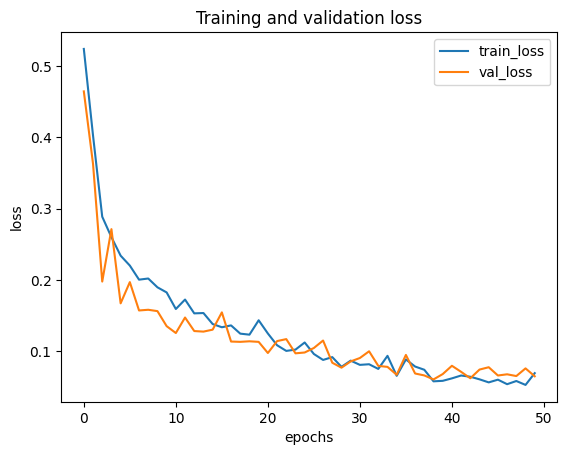

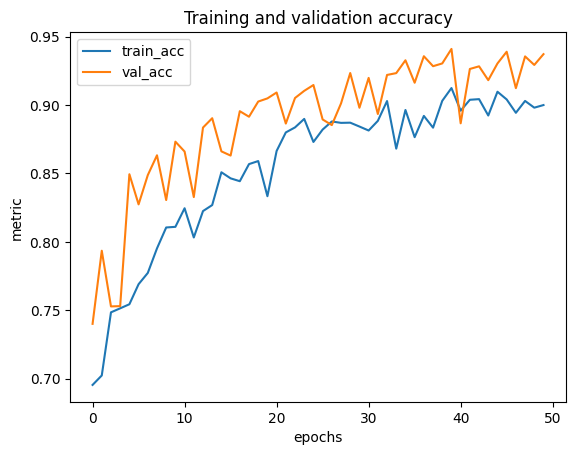

In [ ]:
plt.figure()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
epochs = 50
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('metric')
plt.plot(np.arange(0, epochs), history.history["io_u"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_io_u"], label="val_acc")
plt.legend()

In [ ]:
# load model

path = "#Compile model"
model.load_weights(os.path.join(path, "512", "u_net_softmax.hdf5"))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

In [ ]:
# Calculate accuracy

from sklearn.metrics import accuracy_score
path = "/content/gdrive/MyDrive/DatasetSegm/testing/images"
test_path = "/content/gdrive/MyDrive/DatasetSegm/testing/masks"
images1 = os.listdir(path)
accuracy_tot = 0
for image in images1:
    print(image)
    test_image = cv2.imread(os.path.join(path, image))[:, :, 0]
    test_mask = cv2.imread(os.path.join(test_path,image))[:, :, 0]
    test_image,test_mask = preprocess(test_image, test_mask)
    test_image = img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    prediction = model.predict(test_image)
    test_mask = test_mask/255
    a = test_mask.flatten()
    b = prediction[0,:,:,0].flatten()
    a = a.astype(int)
    b = b.astype(int)

    accuracy = accuracy_score(a, b)
    accuracy_tot += accuracy
    print("testing accuracy:", accuracy)

doc_NR.rear.157579_ic_pol.jpg
1/1 [==============================] - 8s 8s/step
testing accuracy: 0.0330657958984375
doc_NR.front.110227_ic_gbr.jpg
1/1 [==============================] - 14s 14s/step
testing accuracy: 0.08083343505859375
doc_NR.rear.110228_ic_gbr.jpg
1/1 [==============================] - 15s 15s/step
testing accuracy: 0.14485931396484375
ic_CIE.front.8969.jpg
1/1 [==============================] - 11s 11s/step
testing accuracy: 0.7644119262695312
ic_CIE.front.7816.jpg
1/1 [==============================] - 7s 7s/step
testing accuracy: 0.8216476440429688
doc_NR.rear.132207_ic_swi.jpg
1/1 [==============================] - 8s 8s/step
testing accuracy: 0.0102081298828125
ic_CIE.front.7638.jpg
1/1 [==============================] - 9s 9s/step
testing accuracy: 0.7436866760253906
doc_NR.front.157578_ic_pol.jpg
1/1 [==============================] - 9s 9s/step
testing accuracy: 0.08006668090820312
ic_CIE.front.9594.jpg
1/1 [==============================] - 7s 7s/step
testi

In [ ]:
accuracy_tot1 = accuracy_tot / len(images1)
print(accuracy_tot, accuracy_tot1)

45.84211730957031 0.7162830829620361


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

prediction = model.predict(test_generator)

8/8 [==============================] - 528s 66s/step


IndexError: ignored

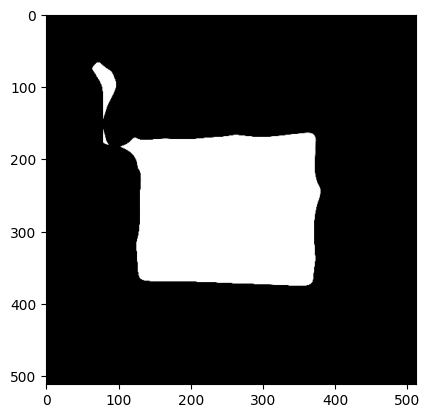

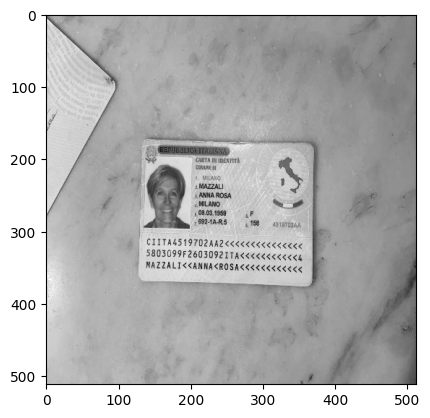

<Figure size 640x480 with 0 Axes>

In [ ]:
# predict

from sklearn.metrics import accuracy_score
path = "MY_PATH"
test_path = "MY_PATH"
images1 = os.listdir(path)
accuracy_tot = 0
# for image in images1:
  # if not "doc_NR" in image:
import random
rand = random.randint(0, 63)
test_image = cv2.imread(os.path.join(path, images1[rand]))[:, :, 0]
test_mask = cv2.imread(os.path.join(test_path,images1[rand]))[:, :, 0]
test_image,test_mask = preprocess(test_image, test_mask)
test_image = img_to_array(test_image)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)
pred = copy.copy(prediction)
pred [prediction > 0.5] = 1
pred [pred < 0.5] = 0
plt.figure()
print("prediction")
plt.imshow(prediction[0,:,:,0], cmap='gray')
plt.figure()
print("pred")
plt.imshow(pred[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(test_mask, cmap='gray')
plt.figure()
plt.imshow(test_image[0,:,:,0], cmap='gray')
a = test_mask.flatten()
b = prediction[0,:,:,0].flatten()
a = a.astype(int)
b = b.astype(int)

accuracy = accuracy_score(a, b)
accuracy_tot += accuracy

In [ ]:
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])(a,b)
print("iou:", iou)